In [3]:
# Importing librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import display, HTML
import time
import gc
from contextlib import contextmanager
import warnings
import re

In [4]:
# Setting pandas options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

# Setting warnings options
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

# Data description

* __application_{train|test}.csv__
    * This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
    * Static data for all applications. One row represents one loan in our data sample.
* __bureau.csv__
    * All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
    * For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.
* __bureau_balance.csv__
    * Monthly balances of previous credits in Credit Bureau.
    * This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.
* __POS_CASH_balance.csv__
    * Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
    * This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.
* __credit_card_balance.csv__
    * Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
    * This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.
* __previous_application.csv__
    * All previous applications for Home Credit loans of clients who have loans in our sample.
    * There is one row for each previous application related to loans in our data sample.
* __installments_payments.csv__
    * Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
    * There is a) one row for every payment that was made plus b) one row each for missed payment.
    * One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

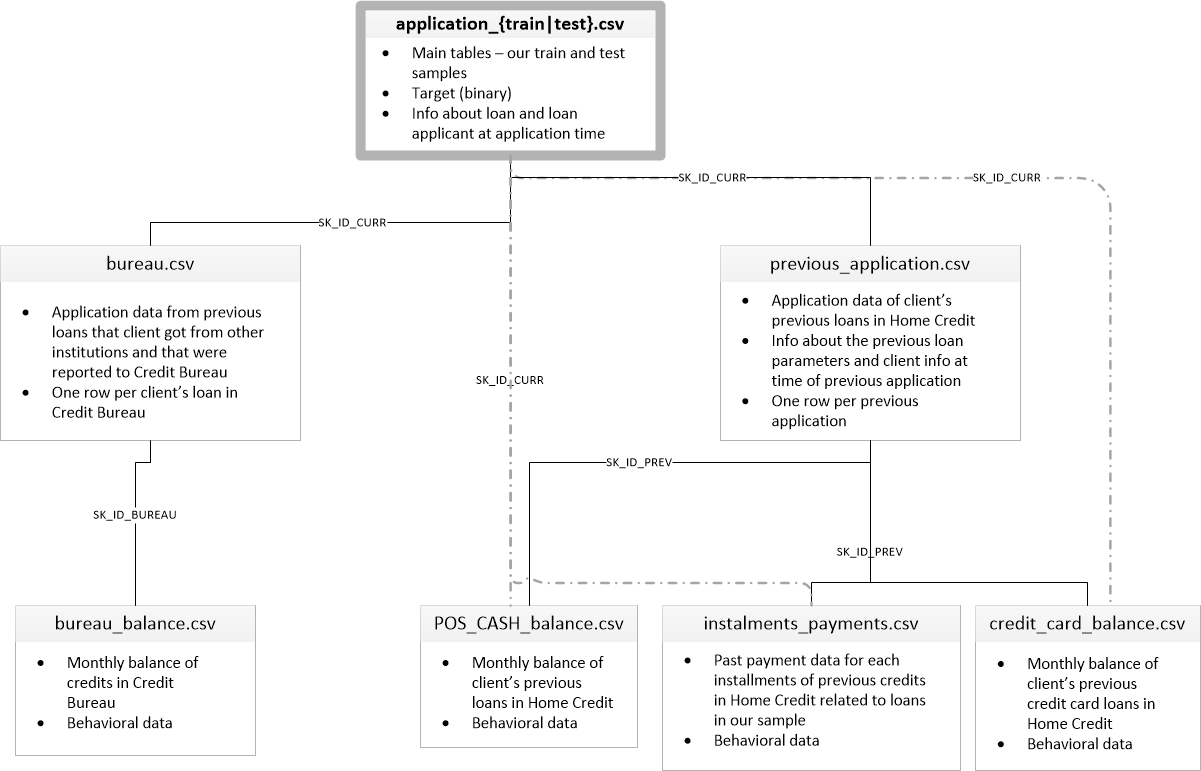

\+ __HomeCredit_columns_description.csv__ ==> This file contains descriptions for the columns in the various data files.

# Data loading and preview

In [7]:
# path to folder with data
path = './Projet+Mise+en+prod+-+home-credit-default-risk/'

In [112]:
# data files within this folder
files = []
for filename in os.listdir(path):
    files.append(filename.split('.')[0])
files

['application_test',
 'application_train',
 'bureau',
 'bureau_balance',
 'credit_card_balance',
 'HomeCredit_columns_description',
 'installments_payments',
 'POS_CASH_balance',
 'previous_application',
 'sample_submission']

In [113]:
# removal of the unnecessary files from the list
files.remove('HomeCredit_columns_description')
files.remove('sample_submission')
files

['application_test',
 'application_train',
 'bureau',
 'bureau_balance',
 'credit_card_balance',
 'installments_payments',
 'POS_CASH_balance',
 'previous_application']

In [114]:
# Creation of dfs from these files and quick look at their content
for filename in files:
    print(filename)
    globals()[filename] = pd.read_csv(path+'{}.csv'.format(filename))
    print('shape =', globals()[filename].shape)
    display(HTML(globals()[filename].head(2).to_html()))
    print('-'*100)
    print('-'*100)

application_test
shape = (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.066,0.059,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.059,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
application_train
shape = (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
bureau
shape = (1716428, 17)


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
bureau_balance
shape = (27299925, 3)


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
credit_card_balance
shape = (3840312, 23)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.00,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.08,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
installments_payments
shape = (13605401, 8)


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
POS_CASH_balance
shape = (10001358, 8)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
previous_application
shape = (1670214, 37)


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


# Preprocessing each dataset individually
**_NOTES:_** 
* **_EDA + analysis and adaptation of bits of code from kaggle kernels used as a basis for data preprocessing were performed, but only final code to preprocess each dataset is shown here_**
* **_NaN are not dealt with at this step, they will be just before modelling with (1) imputation by median values for tested models NOT handling NaN and (2) NaN left as such for tested models handling them_**

kaggle kernels used = 
* https://www.kaggle.com/anlgvrk/home-credit-xgboost-dsmlbc4-gr2
* https://www.kaggle.com/jsaguiar/lightgbm-with-simple-features/script
* https://www.kaggle.com/araul3927/home-credit-risk-fe-to-predictivemodel
* https://www.kaggle.com/kbakshi98/exploring-loan-repayment-prediction
* https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction
* https://www.kaggle.com/danilz/merge-all-data-base-glm-vs-xgb-explained-0-763
* https://notebook.community/Diyago/Machine-Learning-scripts/classification/Kaggle%20Home%20Credit%20Default%20Risk/lightGBM%20


## General functions 
### From kaggle kernels

In [10]:
# Defining one-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns


# Defining Sin-cos transformation for cyclic features
def encode(df, col, max_val):
    df[col + '_SIN'] = np.sin(2 * np.pi * df[col]/max_val)
    df[col + '_COS'] = np.cos(2 * np.pi * df[col]/max_val)
    return df


# Defining dynamic rare encoding for column categories
def dyn_rare_encoder(df, columns, rare_percent):
    for col in columns:
        tmp = df[col].value_counts() / len(df) * 100
        rare_labels = tmp[tmp < rare_percent].index
        df[col] = np.where(df[col].isin(rare_labels), 'Other', df[col])
    return df


############## Remark ##############
#nan_as_category: boolean, optional (default=True)
    #If True includes NaNs as one of the categories and also applies target encoding for this subgroup.

### From this notebook -- for EDA

In [11]:
def analyse_col_distr(df):
    '''Function to provide information
    for each feature of a df in terms of
    NaN, unique values, distribution'''
    num_feat_with_nan = []
    cat_feat_with_nan = []
    discrete_feat_with_nan = []
    print('df shape = {}'.format(df.shape))
    print('nb of duplicates = {}'.format(df.duplicated().sum()))
    for col in df.columns:
        print('-'*40)
        print('-'*40)
        print(col, ' -- dtype = ', df[col].dtype)
        print('-'*20)
        print('Nb of Nan = {} out of {}'.format(df[col].isna().sum(), df.shape[0]))
        print('-'*20)
        if df[col].dtype == object or df[col].dtype == bool:
            if df[col].isna().sum() > 0:
                cat_feat_with_nan.append(col)
            print('Nb unique values = {}'.format(len(df[col].unique().tolist())))
            print('--- Valeurs uniques :')
            if len(df[col].unique().tolist()) < 15:
                print(df[col].value_counts(dropna=False))
            else:
                plt.figure(figsize=(6,4))
                plt.title(col, fontsize=16, color='darkred', weight=800)
                g = sns.countplot(x=col, data=df)
                g.tick_params(axis='x', rotation=90)
        if df[col].dtype == 'int64':
            if len(df[col].unique().tolist()) < 15:
                if df[col].isna().sum() > 0:
                    cat_feat_with_nan.append(col)
                print('categorical-like')
                print('Nb unique values = {}'.format(len(df[col].unique().tolist())))
                print(df[col].value_counts(dropna=False))
            elif len(df[col].unique().tolist()) > 100:
                if df[col].isna().sum() > 0:
                    num_feat_with_nan.append(col)
                print('continuous-like')
                plt.figure(figsize=(6,4))
                plt.title(col, fontsize=16, color='darkred', weight=800)
                g = sns.histplot(x=col, data=df, kde=True)
                g.tick_params(axis='x', rotation=90)
            else:
                if df[col].isna().sum() > 0:
                    discrete_feat_with_nan.append(col)
                print('discrete-like')
                plt.figure(figsize=(6,4))
                plt.title(col, fontsize=16, color='darkred', weight=800)
                g = sns.countplot(x=col, data=df)
                g.tick_params(axis='x', rotation=90)
        if df[col].dtype == float:
            if df[col].isna().sum() > 0:
                num_feat_with_nan.append(col)
            plt.figure(figsize=(6,4))
            plt.title(col, fontsize=16, color='darkred', weight=800)
            g = sns.histplot(x=col, data=df, kde=True)
            g.tick_params(axis='x', rotation=90)
    print('-' * 100)
    print('-' * 100)
    print('numeric features with NaN are {}'.format(num_feat_with_nan))
    print('-'*40)
    print('categorical features with NaN are {}'.format(cat_feat_with_nan))
    print('-'*40)
    print('discrete features with NaN are {}'.format(discrete_feat_with_nan))

def simplified_analyse_col_distr(df):
    '''Function to provide information
    for each feature of a df in terms of NaN,
    and of unique values for categorical features'''
    num_feat_with_nan = []
    num_or_cat_feat_with_nan = []
    cat_feat_with_nan = []
    print('df shape = {}'.format(df.shape))
    print('nb of duplicates = {}'.format(df.duplicated().sum()))
    for col in df.columns:
        print('-'*40)
        print('-'*40)
        print(col, ' -- dtype = ', df[col].dtype)
        print('-'*20)
        print('Nb of Nan = {} out of {}'.format(df[col].isna().sum(), df.shape[0]))
        print('-'*20)
        if df[col].dtype == object or df[col].dtype == bool:
            if df[col].isna().sum() > 0:
                cat_feat_with_nan.append(col)
            print('Nb unique values = {}'.format(len(df[col].unique().tolist())))
            print('--- Valeurs uniques :')
            if len(df[col].unique().tolist()) < 30:
                print(df[col].value_counts(dropna=False))
            else:
                print('More than 30 unique values')
        if df[col].dtype == 'int64':
            print('min =', np.min(df[col]))
            print('max =', np.max(df[col]))
            print('mean =', np.mean(df[col]))
            print('std =', np.std(df[col]))
            print('nan_std =', np.nanstd(df[col]))
            print('Relative_nan_std =', (np.nanstd(df[col])*100)/np.mean(df[col]))
            if df[col].isna().sum() > 0:
                num_or_cat_feat_with_nan = [].append(col)
        if df[col].dtype == float:
            print('min =', np.min(df[col]))
            print('max =', np.max(df[col]))
            print('mean =', np.mean(df[col]))
            print('std =', np.std(df[col]))
            print('nan_std =', np.nanstd(df[col]))
            print('Relative_nan_std =', (np.nanstd(df[col])*100)/np.mean(df[col]))
            if df[col].isna().sum() > 0:
                num_feat_with_nan.append(col)
    print('-' * 100)
    print('-' * 100)
    print('numeric features with NaN are {}'.format(num_feat_with_nan))
    print('-'*40)
    print('categorical features with NaN are {}'.format(cat_feat_with_nan))
    print('-'*40)
    print('int64 features with NaN are {}'.format(num_or_cat_feat_with_nan))

In [12]:
def check_encoded_cat_cols(df, cat_cols):
    print('nb of categorical columns created though OHE = ', len(cat_cols))
    print('-' * 20)
    print(cat_cols)
    print('-' * 100)
    cat_cols_uniq_val_list = []
    cat_cols_nan_list = []
    for col in cat_cols:
        print(col)
        print('Nb of Nan = {} out of {}'.format(df[col].isna().sum(), df.shape[0]))
        print('Nb of unique values = {}'.format(len(df[col].unique().tolist())))
        cat_cols_nan_list.append(df[col].isna().sum())
        cat_cols_uniq_val_list.append(len(df[col].unique().tolist()))
        print('-'*20)
    print('-' * 100)
    print('nb of cat_cols with NaN =', sum(1 for nb_nan in cat_cols_nan_list if nb_nan > 0))
    if np.max(cat_cols_uniq_val_list) > 2:
        print('OHE issue with {} new cat_cols generated'\
              .format(sum(1 for nb_uniq_val in cat_cols_uniq_val_list if nb_uniq_val > 2)))
    else: print('No OHE issue!!')

In [13]:
def check_nan(df):
    for col in df.columns.tolist():
        print('nan in', col, ':', df[col].isna().sum(),
              '(ratio of', round(df[col].isna().sum()/df.shape[0], 2), ')')

## 'application_train' dataset: test of full and clean code to preprocess it

* **Full and clean code**

In [8]:
def application_train(num_rows=None, nan_as_category=True):
    # Read and merge data
    df = pd.read_csv(path+'application_train.csv', nrows=num_rows)
    print("Train df shape: {}".format(df.shape))

    # Removing 4 applications with XNA as CODE_GENDER
    df = df[df['CODE_GENDER'] != 'XNA']

    # Deleting FLAG_MOBIL because there is only 1 person without mobile phone
    df.drop('FLAG_MOBIL', axis=1, inplace=True)
    df.drop('FLAG_CONT_MOBILE', axis=1, inplace=True)

    # Replacement of DAYS_EMPLOYED == 365243 (i.e. concerns Pensioners and unemployed people only) and homogenization
    df['DAYS_EMPLOYED'] = np.where(df['NAME_INCOME_TYPE']=='Pensioner', 0, df['DAYS_EMPLOYED'])
    df['DAYS_EMPLOYED'] = np.where(df['NAME_INCOME_TYPE']=='Unemployed', 0, df['DAYS_EMPLOYED'])

    # Changing rare categories of NAME_INCOME_TYPE with the similar categories
    df.loc[df['NAME_INCOME_TYPE'] == 'Student', 'NAME_INCOME_TYPE'] = 'Pensioner'
    df.loc[df['NAME_INCOME_TYPE'] == 'Maternity leave', 'NAME_INCOME_TYPE'] = 'Pensioner'
    df.loc[df['NAME_INCOME_TYPE'] == 'Unemployed', 'NAME_INCOME_TYPE'] = 'Pensioner'
    df.loc[df['NAME_INCOME_TYPE'] == 'Businessman', 'NAME_INCOME_TYPE'] = 'Commercial associate'
    
    ####ADDED#### Changing rare categories of OCCUPATION_TYPE with similar categories
    df.loc[df['OCCUPATION_TYPE'] == 'Waiters/barmen staff', 'OCCUPATION_TYPE'] = 'Cooking staff'
    df.loc[df['OCCUPATION_TYPE'] == 'Low-skill Laborers', 'OCCUPATION_TYPE'] = 'Laborers'
    df.loc[df['OCCUPATION_TYPE'] == 'Realty agents', 'OCCUPATION_TYPE'] = 'Sales staff'
    df.loc[df['OCCUPATION_TYPE'] == 'Secretaries', 'OCCUPATION_TYPE'] = 'Core staff'
    df.loc[df['OCCUPATION_TYPE'] == 'IT staff', 'OCCUPATION_TYPE'] = 'High skill tech staff'
    df.loc[df['OCCUPATION_TYPE'] == 'HR staff', 'OCCUPATION_TYPE'] = 'Core staff'

    # Dynamic rare encoding
    df = dyn_rare_encoder(df, ['ORGANIZATION_TYPE'], rare_percent=1.9)

    #  Changing unknown family status with the most observed category
    df['NAME_FAMILY_STATUS'].replace('Unknown', 'Married', inplace=True)

    # Changing weekdays with integer values
    weekday_dict = {'MONDAY': 1, 'TUESDAY': 2, 'WEDNESDAY': 3, 'THURSDAY': 4, 'FRIDAY': 5, 'SATURDAY': 6, 'SUNDAY': 7}
    df.replace({'WEEKDAY_APPR_PROCESS_START': weekday_dict}, inplace=True)
    # Creating sin-cos transformed features
    df = encode(df, 'WEEKDAY_APPR_PROCESS_START', 7)
    df = encode(df, 'HOUR_APPR_PROCESS_START', 23)
    # Deleting initial WEEKDAY_APPR_PROCESS_START and HOUR_APPR_PROCESS_START features
    df.drop(['WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START'], axis=1, inplace=True)

    # Creating new features 
        # simple percentages
    df['NEW_DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['NEW_INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['NEW_INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['NEW_ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['NEW_PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    df['NEW_INC_PER_CHLD'] = df['AMT_INCOME_TOTAL'] / (1 + df['CNT_CHILDREN'])
        # Loan to Value Ratio (LVR)
    df['NEW_LVR'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
        # LVR_RISK assesment feature
    df.loc[df['NEW_LVR'] >= 0.80, 'NEW_LVR_RISK'] = 1
    df.loc[df['NEW_LVR'] < 0.80, 'NEW_LVR_RISK'] = 0
        # Mean and standard deviation of Scores from External Sources
    df['NEW_EXT_SOURCE_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    df['NEW_EXT_SOURCE_STD'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    df['NEW_EXT_SOURCE_STD'] = np.where(df['NEW_EXT_SOURCE_MEAN'].isna() == False,
                                        df['NEW_EXT_SOURCE_STD'].fillna(0),
                                        df['NEW_EXT_SOURCE_STD']) # NaN due to single ext score replaced by 0
    # Ages of customers
    df['NEW_AGE'] = df['DAYS_BIRTH'] / -365
    # NEW_AGE_SEGMENT segments
    df.loc[df['NEW_AGE'] <= 34, 'NEW_AGE_SEGMENT'] = 'AGE_GRP_1'
    df.loc[(df['NEW_AGE'] > 34) & (df['NEW_AGE'] <= 54), 'NEW_AGE_SEGMENT'] = 'AGE_GRP_2'
    df.loc[df['NEW_AGE'] > 54, 'NEW_AGE_SEGMENT'] = 'AGE_GRP_3'
    # Number of documents provided
    df['NEW_NB_TOTAL_DOC'] = df.loc[:, 'FLAG_DOCUMENT_2':'FLAG_DOCUMENT_21'].sum(axis=1)
    df.drop(df.loc[:, 'FLAG_DOCUMENT_2':'FLAG_DOCUMENT_21'], axis=1, inplace=True)
    # Product-Credit-Salary relation
    df["NEW_PROD_CRED_SALARY"] = (df["AMT_GOODS_PRICE"] - df["AMT_CREDIT"]) / df["AMT_INCOME_TOTAL"]

    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])

    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    gc.collect()
    return df

* **testing it**

In [195]:
num_rows = 10000
df = application_train(num_rows)
df.head(2)

Train df shape: (10000, 122)


,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,WEEKDAY_APPR_PROCESS_START_SIN,WEEKDAY_APPR_PROCESS_START_COS,HOUR_APPR_PROCESS_START_SIN,HOUR_APPR_PROCESS_START_COS,NEW_DAYS_EMPLOYED_PERC,NEW_INCOME_CREDIT_PERC,NEW_INCOME_PER_PERSON,NEW_ANNUITY_INCOME_PERC,NEW_PAYMENT_RATE,NEW_INC_PER_CHLD,NEW_LVR,NEW_LVR_RISK,NEW_EXT_SOURCE_MEAN,NEW_EXT_SOURCE_STD,NEW_AGE,NEW_NB_TOTAL_DOC,NEW_PROD_CRED_SALARY,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_nan,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Other,NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_nan,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_nan,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_EDUCATION_TYPE_nan,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_FAMILY_STATUS_nan,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_HOUSING_TYPE_nan,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_nan,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_XNA,ORGANIZATION_TYPE_nan,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,FONDKAPREMONT_MODE_nan,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,HOUSETYPE_MODE_nan,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,W

In [14]:
num_rows = None
df = application_train(num_rows)
simplified_analyse_col_distr(df)

Train df shape: (307511, 122)
df shape = (307507, 188)
nb of duplicates = 0
----------------------------------------
----------------------------------------
SK_ID_CURR  -- dtype =  int64
--------------------
Nb of Nan = 0 out of 307507
--------------------
min = 100002
max = 456255
mean = 278181.5272562901
std = 102789.96584759024
nan_std = 102789.96584759005
Relative_nan_std = 36.950679961178416
----------------------------------------
----------------------------------------
TARGET  -- dtype =  int64
--------------------
Nb of Nan = 0 out of 307507
--------------------
min = 0
max = 1
mean = 0.08072986956394489
std = 0.272419818889513
nan_std = 0.27241981889013384
Relative_nan_std = 337.44612788498847
----------------------------------------
----------------------------------------
CODE_GENDER  -- dtype =  int64
--------------------
Nb of Nan = 0 out of 307507
--------------------
min = 0
max = 1
mean = 0.658352492788782
std = 0.47426204573866704
nan_std = 0.4742620457379851
Relativ

max = 0.8960095494948396
mean = 0.5108562869992801
std = 0.19484291376199478
nan_std = 0.19484291376198312
Relative_nan_std = 38.140455294476524
----------------------------------------
----------------------------------------
APARTMENTS_AVG  -- dtype =  float64
--------------------
Nb of Nan = 156060 out of 307507
--------------------
min = 0.0
max = 1.0
mean = 0.11744202262179049
std = 0.10824040098060825
nan_std = 0.10824040098060743
Relative_nan_std = 92.16496664842371
----------------------------------------
----------------------------------------
BASEMENTAREA_AVG  -- dtype =  float64
--------------------
Nb of Nan = 179942 out of 307507
--------------------
min = 0.0
max = 1.0
mean = 0.088442514796379
std = 0.08243852218894432
nan_std = 0.08243852218895535
Relative_nan_std = 93.21141803662341
----------------------------------------
----------------------------------------
YEARS_BEGINEXPLUATATION_AVG  -- dtype =  float64
--------------------
Nb of Nan = 150006 out of 307507
----

Relative_nan_std = 92.55383001037939
----------------------------------------
----------------------------------------
BASEMENTAREA_MEDI  -- dtype =  float64
--------------------
Nb of Nan = 179942 out of 307507
--------------------
min = 0.0
max = 1.0
mean = 0.08795513894877197
std = 0.08217911176168008
nan_std = 0.08217911176167202
Relative_nan_std = 93.43298497832616
----------------------------------------
----------------------------------------
YEARS_BEGINEXPLUATATION_MEDI  -- dtype =  float64
--------------------
Nb of Nan = 150006 out of 307507
--------------------
min = 0.0
max = 1.0
mean = 0.9777521933193447
std = 0.059897685022034255
nan_std = 0.05989768502202533
Relative_nan_std = 6.126059898539352
----------------------------------------
----------------------------------------
YEARS_BUILD_MEDI  -- dtype =  float64
--------------------
Nb of Nan = 204486 out of 307507
--------------------
min = 0.0
max = 1.0
mean = 0.7557463488027352
std = 0.11206513261416057
nan_std = 0.1

nan_std = 0.6510959570767901
Relative_nan_std = -429.1098014782384
----------------------------------------
----------------------------------------
HOUR_APPR_PROCESS_START_SIN  -- dtype =  float64
--------------------
Nb of Nan = 0 out of 307507
--------------------
min = -0.9976687691905393
max = 0.9976687691905392
mean = -0.1026387934720279
std = 0.6319069915764131
nan_std = 0.6319069915767136
Relative_nan_std = -615.6609700882025
----------------------------------------
----------------------------------------
HOUR_APPR_PROCESS_START_COS  -- dtype =  float64
--------------------
Nb of Nan = 0 out of 307507
--------------------
min = -0.9906859460363308
max = 1.0
mean = -0.6600429410310529
std = 0.39306761259178263
nan_std = 0.3930676125917431
Relative_nan_std = -59.55182430672348
----------------------------------------
----------------------------------------
NEW_DAYS_EMPLOYED_PERC  -- dtype =  float64
--------------------
Nb of Nan = 0 out of 307507
--------------------
min = -0.

## 'Bureau' and 'Bureau_balance' datasets: test of full and clean code to preprocess them

* **Full and clean code**

In [15]:
def bureau_and_balance(num_rows = None, nan_as_category = True):
    # Read data
    bu = pd.read_csv(path+'bureau.csv', nrows = num_rows)
    bb = pd.read_csv(path+'bureau_balance.csv', nrows = num_rows)
    print("bu shape: {}, bb shape: {}".format(bu.shape, bb.shape))
    
    # Bureau dataset: 
        # dealing with rare unique values: CNT_CREDIT_PROLONG turned into a binary feature - not done as summed later
    #prolong = [1,2,3,4,5,6,7,8,9]
    #bu['CNT_CREDIT_PROLONG'].replace(prolong, 1, inplace= True)
        # creating new features through aggregations: Active and closed credit counts and ratio
    temp_bu = bu[['SK_ID_CURR', 'CREDIT_ACTIVE']]
    temp_bu = pd.get_dummies(temp_bu)
    temp_bu = temp_bu.groupby('SK_ID_CURR').agg({'CREDIT_ACTIVE_Active':'sum','CREDIT_ACTIVE_Closed':'sum' })
    temp_bu.columns = ['CREDIT_ACTIVE_Active__count','CREDIT_ACTIVE_Closed__count']
    temp_bu['CREDIT_ACTIVE_ActiveClosed_ratio'] = (temp_bu['CREDIT_ACTIVE_Active__count']
                                                   / (temp_bu['CREDIT_ACTIVE_Active__count']
                                                      + temp_bu['CREDIT_ACTIVE_Closed__count']))
        # merging those new features to original dataframe 'bu'
    bu = bu.join(temp_bu, on=['SK_ID_CURR'], how='left')
    del temp_bu
    gc.collect()
        # encoding of categorical features
    bu, bu_cat = one_hot_encoder(bu, nan_as_category)

    # Bureau_Balance dataset: 
        # simplifiying STATUS categories
    Status_DPD = ['1','2','3','4','5']
    bb['Simplified_STATUS'] = np.where(bb['STATUS'].isin(Status_DPD), 'DPD', bb['STATUS'])
    bb.drop('STATUS', inplace=True, axis = 1)
        # encoding categorical features
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
        # Performing aggregations and merging with bu
            # defining aggregations
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
            # performing them
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "__" + e[1].lower() for e in bb_agg.columns.tolist()])
            # merging with bu
    bu = bu.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bu.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau&Bureau_Balance_agg: creating new features through (further) aggregations
        # defining numeric features and their aggregations
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CREDIT_ACTIVE_Active__count': ['max'],
        'CREDIT_ACTIVE_Closed__count' : ['max'],
        'CREDIT_ACTIVE_ActiveClosed_ratio' : ['mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE__min': ['min'],
        'MONTHS_BALANCE__max': ['max'],
        'MONTHS_BALANCE__size': ['mean', 'sum']
    }
        # defining categorical features and their aggregations
    cat_aggregations = {}
    for cat in bu_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "__mean"] = ['mean']
        # performing all those aggregations on all individuals
    bureau_agg = bu.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "__" + e[1].lower() for e in bureau_agg.columns.tolist()])
        # performing aggregations on numeric features for individuals with ACTIVE credits
    active = bu[bu['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['BURO_active_' + e[0] + "__" + e[1].lower() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
        # performing aggregations on numeric features for individuals with CLOSED credits
    closed = bu[bu['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['BURO_closed_' + e[0] + "__" + e[1].lower() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bu
    gc.collect()
                                                   
    return bureau_agg

* **Testing it**

In [531]:
num_rows = 10000
bureau_agg = bureau_and_balance(num_rows)
bureau_agg.head(2)

bu shape: (10000, 17), bb shape: (10000, 3)


,BURO_DAYS_CREDIT__min,BURO_DAYS_CREDIT__max,BURO_DAYS_CREDIT__mean,BURO_DAYS_CREDIT__var,BURO_DAYS_CREDIT_ENDDATE__min,BURO_DAYS_CREDIT_ENDDATE__max,BURO_DAYS_CREDIT_ENDDATE__mean,BURO_DAYS_CREDIT_UPDATE__mean,BURO_CREDIT_DAY_OVERDUE__max,BURO_CREDIT_DAY_OVERDUE__mean,BURO_AMT_CREDIT_MAX_OVERDUE__mean,BURO_AMT_CREDIT_SUM__max,BURO_AMT_CREDIT_SUM__mean,BURO_AMT_CREDIT_SUM__sum,BURO_AMT_CREDIT_SUM_DEBT__max,BURO_AMT_CREDIT_SUM_DEBT__mean,BURO_AMT_CREDIT_SUM_DEBT__sum,BURO_AMT_CREDIT_SUM_OVERDUE__mean,BURO_AMT_CREDIT_SUM_LIMIT__mean,BURO_AMT_CREDIT_SUM_LIMIT__sum,BURO_AMT_ANNUITY__max,BURO_AMT_ANNUITY__mean,BURO_CREDIT_ACTIVE_Active__count__max,BURO_CREDIT_ACTIVE_Closed__count__max,BURO_CREDIT_ACTIVE_ActiveClosed_ratio__mean,BURO_CNT_CREDIT_PROLONG__sum,BURO_MONTHS_BALANCE__min__min,BURO_MONTHS_BALANCE__max__max,BURO_MONTHS_BALANCE__size__mean,BURO_MONTHS_BALANCE__size__sum,BURO_CREDIT_ACTIVE_Active__mean,BURO_CREDIT_ACTIVE_Bad debt__mean,BURO_CREDIT_ACTIVE_Closed__mean,BURO_CREDIT_ACTIVE_Sold__mean,BURO_CREDIT_ACTIVE_nan__mean,BURO_CREDIT_CURRENCY_currency 1__mean,BURO_CREDIT_CURRENCY_currency 2__mean,BURO_CREDIT_CURRENCY_currency 4__mean,BURO_CREDIT_CURRENCY_nan__mean,BURO_CREDIT_TYPE_Another type of loan__mean,BURO_CREDIT_TYPE_Car loan__mean,BURO_CREDIT_TYPE_Consumer credit__mean,BURO_CREDIT_TYPE_Credit card__mean,BURO_CREDIT_TYPE_Loan for business development__mean,BURO_CREDIT_TYPE_Loan for working capital replenishment__mean,BURO_CREDIT_TYPE_Microloan__mean,BURO_CREDIT_TYPE_Mortgage__mean,BURO_CREDIT_TYPE_Real estate loan__mean,BURO_CREDIT_TYPE_Unknown type of loan__mean,BURO_CREDIT_TYPE_nan__mean,BURO_Simplified_STATUS_0__mean__mean,BURO_Simplified_STATUS_C__mean__mean,BURO_Simplified_STATUS_DPD__mean__mean,BURO_Simplified_STATUS_X__mean__mean,BURO_Simplified_STATUS_nan__mean__mean,BURO_active_DAYS_CREDIT__min,BURO_active_DAYS_CREDIT__max,BURO_active_DAYS_CREDIT__mean,BURO_active_DAYS_CREDIT__var,BURO_active_DAYS_CREDIT_ENDDATE__min,BURO_active_DAYS_CREDIT_ENDDATE__max,BURO_active_DAYS_CREDIT_ENDDATE__mean,BURO_active_DAYS_CREDIT_UPDATE__mean,BURO_active_CREDIT_DAY_OVERDUE__max,BURO_active_CREDIT_DAY_OVERDUE__mean,BURO_active_AMT_CREDIT_MAX_OVERDUE__mean,BURO_active_AMT_CREDIT_SUM__max,BURO_active_AMT_CREDIT_SUM__mean,BURO_active_AMT_CREDIT_SUM__sum,BURO_active_AMT_CREDIT_SUM_DEBT__max,BURO_active_AMT_CREDIT_SUM_DEBT__mean,BURO_active_AMT_CREDIT_SUM_DEBT__sum,BURO_active_AMT_CREDIT_SUM_OVERDUE__mean,BURO_active_AMT_CREDIT_SUM_LIMIT__mean,BURO_active_AMT_CREDIT_SUM_LIMIT__sum,BURO_active_AMT_ANNUITY__max,BURO_active_AMT_ANNUITY__mean,BURO_active_CREDIT_ACTIVE_Active__count__max,BURO_active_CREDIT_ACTIVE_Closed__count__max,BURO_active_CREDIT_ACTIVE_ActiveClosed_ratio__mean,BURO_active_CNT_CREDIT_PROLONG__sum,BURO_active_MONTHS_BALANCE__min__min,BURO_active_MONTHS_BALANCE__max__max,BURO_active_MONTHS_BALANCE__size__mean,BURO_active_MONTHS_BALANCE__size__sum,BURO_closed_DAYS_CREDIT__min,BURO_closed_DAYS_CREDIT__max,BURO_closed_DAYS_CREDIT__mean,BURO_closed_DAYS_CREDIT__var,BURO_closed_DAYS_CREDIT_ENDDATE__min,BURO_closed_DAYS_CREDIT_ENDDATE__max,BURO_closed_DAYS_CREDIT_ENDDATE__mean,BURO_closed_DAYS_CREDIT_UPDATE__mean,BURO_closed_CREDIT_DAY_OVERDUE__max,BURO_closed_CREDIT_DAY_OVERDUE__mean,BURO_closed_AMT_CREDIT_MAX_OVERDUE__mean,BURO_closed_AMT_CREDIT_SUM__max,BURO_closed_AMT_CREDIT_SUM__mean,BURO_closed_AMT_CREDIT_SUM__sum,BURO_closed_AMT_CREDIT_SUM_DEBT__max,BURO_closed_AMT_CREDIT_SUM_DEBT__mean,BURO_closed_AMT_CREDIT_SUM_DEBT__sum,BURO_closed_AMT_CREDIT_SUM_OVERDUE__mean,BURO_closed_AMT_CREDIT_SUM_LIMIT__mean,BURO_closed_AMT_CREDIT_SUM_LIMIT__sum,BURO_closed_AMT_ANNUITY__max,BURO_closed_AMT_ANNUITY__mean,BURO_closed_CREDIT_ACTIVE_Active__count__max,BURO_closed_CREDIT_ACTIVE_Closed__count__max,BURO_closed_CREDIT_ACTIVE_ActiveClosed_ratio__mean,BURO_closed_CNT_CREDIT_PROLONG__sum,BURO_closed_MONTHS_BALANCE__min__min,BURO_closed_MONTHS_BALANCE__max__max,BURO_closed_MONTHS_BALANCE__size__mean,BURO_closed_MONTHS_BALANCE__size_

In [16]:
num_rows = None
bureau_agg = bureau_and_balance(num_rows)
bureau_agg.head(0)

bu shape: (1716428, 17), bb shape: (27299925, 3)


,BURO_DAYS_CREDIT__min,BURO_DAYS_CREDIT__max,BURO_DAYS_CREDIT__mean,BURO_DAYS_CREDIT__var,BURO_DAYS_CREDIT_ENDDATE__min,BURO_DAYS_CREDIT_ENDDATE__max,BURO_DAYS_CREDIT_ENDDATE__mean,BURO_DAYS_CREDIT_UPDATE__mean,BURO_CREDIT_DAY_OVERDUE__max,BURO_CREDIT_DAY_OVERDUE__mean,BURO_AMT_CREDIT_MAX_OVERDUE__mean,BURO_AMT_CREDIT_SUM__max,BURO_AMT_CREDIT_SUM__mean,BURO_AMT_CREDIT_SUM__sum,BURO_AMT_CREDIT_SUM_DEBT__max,BURO_AMT_CREDIT_SUM_DEBT__mean,BURO_AMT_CREDIT_SUM_DEBT__sum,BURO_AMT_CREDIT_SUM_OVERDUE__mean,BURO_AMT_CREDIT_SUM_LIMIT__mean,BURO_AMT_CREDIT_SUM_LIMIT__sum,BURO_AMT_ANNUITY__max,BURO_AMT_ANNUITY__mean,BURO_CREDIT_ACTIVE_Active__count__max,BURO_CREDIT_ACTIVE_Closed__count__max,BURO_CREDIT_ACTIVE_ActiveClosed_ratio__mean,BURO_CNT_CREDIT_PROLONG__sum,BURO_MONTHS_BALANCE__min__min,BURO_MONTHS_BALANCE__max__max,BURO_MONTHS_BALANCE__size__mean,BURO_MONTHS_BALANCE__size__sum,BURO_CREDIT_ACTIVE_Active__mean,BURO_CREDIT_ACTIVE_Bad debt__mean,BURO_CREDIT_ACTIVE_Closed__mean,BURO_CREDIT_ACTIVE_Sold__mean,BURO_CREDIT_ACTIVE_nan__mean,BURO_CREDIT_CURRENCY_currency 1__mean,BURO_CREDIT_CURRENCY_currency 2__mean,BURO_CREDIT_CURRENCY_currency 3__mean,BURO_CREDIT_CURRENCY_currency 4__mean,BURO_CREDIT_CURRENCY_nan__mean,BURO_CREDIT_TYPE_Another type of loan__mean,BURO_CREDIT_TYPE_Car loan__mean,BURO_CREDIT_TYPE_Cash loan (non-earmarked)__mean,BURO_CREDIT_TYPE_Consumer credit__mean,BURO_CREDIT_TYPE_Credit card__mean,BURO_CREDIT_TYPE_Interbank credit__mean,BURO_CREDIT_TYPE_Loan for business development__mean,BURO_CREDIT_TYPE_Loan for purchase of shares (margin lending)__mean,BURO_CREDIT_TYPE_Loan for the purchase of equipment__mean,BURO_CREDIT_TYPE_Loan for working capital replenishment__mean,BURO_CREDIT_TYPE_Microloan__mean,BURO_CREDIT_TYPE_Mobile operator loan__mean,BURO_CREDIT_TYPE_Mortgage__mean,BURO_CREDIT_TYPE_Real estate loan__mean,BURO_CREDIT_TYPE_Unknown type of loan__mean,BURO_CREDIT_TYPE_nan__mean,BURO_Simplified_STATUS_0__mean__mean,BURO_Simplified_STATUS_C__mean__mean,BURO_Simplified_STATUS_DPD__mean__mean,BURO_Simplified_STATUS_X__mean__mean,BURO_Simplified_STATUS_nan__mean__mean,BURO_active_DAYS_CREDIT__min,BURO_active_DAYS_CREDIT__max,BURO_active_DAYS_CREDIT__mean,BURO_active_DAYS_CREDIT__var,BURO_active_DAYS_CREDIT_ENDDATE__min,BURO_active_DAYS_CREDIT_ENDDATE__max,BURO_active_DAYS_CREDIT_ENDDATE__mean,BURO_active_DAYS_CREDIT_UPDATE__mean,BURO_active_CREDIT_DAY_OVERDUE__max,BURO_active_CREDIT_DAY_OVERDUE__mean,BURO_active_AMT_CREDIT_MAX_OVERDUE__mean,BURO_active_AMT_CREDIT_SUM__max,BURO_active_AMT_CREDIT_SUM__mean,BURO_active_AMT_CREDIT_SUM__sum,BURO_active_AMT_CREDIT_SUM_DEBT__max,BURO_active_AMT_CREDIT_SUM_DEBT__mean,BURO_active_AMT_CREDIT_SUM_DEBT__sum,BURO_active_AMT_CREDIT_SUM_OVERDUE__mean,BURO_active_AMT_CREDIT_SUM_LIMIT__mean,BURO_active_AMT_CREDIT_SUM_LIMIT__sum,BURO_active_AMT_ANNUITY__max,BURO_active_AMT_ANNUITY__mean,BURO_active_CREDIT_ACTIVE_Active__count__max,BURO_active_CREDIT_ACTIVE_Closed__count__max,BURO_active_CREDIT_ACTIVE_ActiveClosed_ratio__mean,BURO_active_CNT_CREDIT_PROLONG__sum,BURO_active_MONTHS_BALANCE__min__min,BURO_active_MONTHS_BALANCE__max__max,BURO_active_MONTHS_BALANCE__size__mean,BURO_active_MONTHS_BALANCE__size__sum,BURO_closed_DAYS_CREDIT__min,BURO_closed_DAYS_CREDIT__max,BURO_closed_DAYS_CREDIT__mean,BURO_closed_DAYS_CREDIT__var,BURO_closed_DAYS_CREDIT_ENDDATE__min,BURO_closed_DAYS_CREDIT_ENDDATE__max,BURO_closed_DAYS_CREDIT_ENDDATE__mean,BURO_closed_DAYS_CREDIT_UPDATE__mean,BURO_closed_CREDIT_DAY_OVERDUE__max,BURO_closed_CREDIT_DAY_OVERDUE__mean,BURO_closed_AMT_CREDIT_MAX_OVERDUE__mean,BURO_closed_AMT_CREDIT_SUM__max,BURO_closed_AMT_CREDIT_SUM__mean,BURO_closed_AMT_CREDIT_SUM__sum,BURO_closed_AMT_CREDIT_SUM_DEBT__max,BURO_closed_AMT_CREDIT_SUM_DEBT__mean,BURO_closed_AMT_CREDIT_SUM_DEBT__sum,BURO_closed_AMT_CREDIT_SUM_OVERDUE__mean,BURO_closed_AMT_CREDIT_SUM_LIMIT__mean,BURO_closed_AMT_CREDIT_SUM_LIMIT__sum,BURO_closed_AMT_ANNUITY__max,BURO_closed_AMT_ANNUITY__mean,BURO_closed_CREDIT_ACTIVE_

In [534]:
bureau_agg[bureau_agg.index == 215354]

,BURO_DAYS_CREDIT__min,BURO_DAYS_CREDIT__max,BURO_DAYS_CREDIT__mean,BURO_DAYS_CREDIT__var,BURO_DAYS_CREDIT_ENDDATE__min,BURO_DAYS_CREDIT_ENDDATE__max,BURO_DAYS_CREDIT_ENDDATE__mean,BURO_DAYS_CREDIT_UPDATE__mean,BURO_CREDIT_DAY_OVERDUE__max,BURO_CREDIT_DAY_OVERDUE__mean,BURO_AMT_CREDIT_MAX_OVERDUE__mean,BURO_AMT_CREDIT_SUM__max,BURO_AMT_CREDIT_SUM__mean,BURO_AMT_CREDIT_SUM__sum,BURO_AMT_CREDIT_SUM_DEBT__max,BURO_AMT_CREDIT_SUM_DEBT__mean,BURO_AMT_CREDIT_SUM_DEBT__sum,BURO_AMT_CREDIT_SUM_OVERDUE__mean,BURO_AMT_CREDIT_SUM_LIMIT__mean,BURO_AMT_CREDIT_SUM_LIMIT__sum,BURO_AMT_ANNUITY__max,BURO_AMT_ANNUITY__mean,BURO_CREDIT_ACTIVE_Active__count__max,BURO_CREDIT_ACTIVE_Closed__count__max,BURO_CREDIT_ACTIVE_ActiveClosed_ratio__mean,BURO_CNT_CREDIT_PROLONG__sum,BURO_MONTHS_BALANCE__min__min,BURO_MONTHS_BALANCE__max__max,BURO_MONTHS_BALANCE__size__mean,BURO_MONTHS_BALANCE__size__sum,BURO_CREDIT_ACTIVE_Active__mean,BURO_CREDIT_ACTIVE_Bad debt__mean,BURO_CREDIT_ACTIVE_Closed__mean,BURO_CREDIT_ACTIVE_Sold__mean,BURO_CREDIT_ACTIVE_nan__mean,BURO_CREDIT_CURRENCY_currency 1__mean,BURO_CREDIT_CURRENCY_currency 2__mean,BURO_CREDIT_CURRENCY_currency 3__mean,BURO_CREDIT_CURRENCY_currency 4__mean,BURO_CREDIT_CURRENCY_nan__mean,BURO_CREDIT_TYPE_Another type of loan__mean,BURO_CREDIT_TYPE_Car loan__mean,BURO_CREDIT_TYPE_Cash loan (non-earmarked)__mean,BURO_CREDIT_TYPE_Consumer credit__mean,BURO_CREDIT_TYPE_Credit card__mean,BURO_CREDIT_TYPE_Interbank credit__mean,BURO_CREDIT_TYPE_Loan for business development__mean,BURO_CREDIT_TYPE_Loan for purchase of shares (margin lending)__mean,BURO_CREDIT_TYPE_Loan for the purchase of equipment__mean,BURO_CREDIT_TYPE_Loan for working capital replenishment__mean,BURO_CREDIT_TYPE_Microloan__mean,BURO_CREDIT_TYPE_Mobile operator loan__mean,BURO_CREDIT_TYPE_Mortgage__mean,BURO_CREDIT_TYPE_Real estate loan__mean,BURO_CREDIT_TYPE_Unknown type of loan__mean,BURO_CREDIT_TYPE_nan__mean,BURO_Simplified_STATUS_0__mean__mean,BURO_Simplified_STATUS_C__mean__mean,BURO_Simplified_STATUS_DPD__mean__mean,BURO_Simplified_STATUS_X__mean__mean,BURO_Simplified_STATUS_nan__mean__mean,BURO_active_DAYS_CREDIT__min,BURO_active_DAYS_CREDIT__max,BURO_active_DAYS_CREDIT__mean,BURO_active_DAYS_CREDIT__var,BURO_active_DAYS_CREDIT_ENDDATE__min,BURO_active_DAYS_CREDIT_ENDDATE__max,BURO_active_DAYS_CREDIT_ENDDATE__mean,BURO_active_DAYS_CREDIT_UPDATE__mean,BURO_active_CREDIT_DAY_OVERDUE__max,BURO_active_CREDIT_DAY_OVERDUE__mean,BURO_active_AMT_CREDIT_MAX_OVERDUE__mean,BURO_active_AMT_CREDIT_SUM__max,BURO_active_AMT_CREDIT_SUM__mean,BURO_active_AMT_CREDIT_SUM__sum,BURO_active_AMT_CREDIT_SUM_DEBT__max,BURO_active_AMT_CREDIT_SUM_DEBT__mean,BURO_active_AMT_CREDIT_SUM_DEBT__sum,BURO_active_AMT_CREDIT_SUM_OVERDUE__mean,BURO_active_AMT_CREDIT_SUM_LIMIT__mean,BURO_active_AMT_CREDIT_SUM_LIMIT__sum,BURO_active_AMT_ANNUITY__max,BURO_active_AMT_ANNUITY__mean,BURO_active_CREDIT_ACTIVE_Active__count__max,BURO_active_CREDIT_ACTIVE_Closed__count__max,BURO_active_CREDIT_ACTIVE_ActiveClosed_ratio__mean,BURO_active_CNT_CREDIT_PROLONG__sum,BURO_active_MONTHS_BALANCE__min__min,BURO_active_MONTHS_BALANCE__max__max,BURO_active_MONTHS_BALANCE__size__mean,BURO_active_MONTHS_BALANCE__size__sum,BURO_closed_DAYS_CREDIT__min,BURO_closed_DAYS_CREDIT__max,BURO_closed_DAYS_CREDIT__mean,BURO_closed_DAYS_CREDIT__var,BURO_closed_DAYS_CREDIT_ENDDATE__min,BURO_closed_DAYS_CREDIT_ENDDATE__max,BURO_closed_DAYS_CREDIT_ENDDATE__mean,BURO_closed_DAYS_CREDIT_UPDATE__mean,BURO_closed_CREDIT_DAY_OVERDUE__max,BURO_closed_CREDIT_DAY_OVERDUE__mean,BURO_closed_AMT_CREDIT_MAX_OVERDUE__mean,BURO_closed_AMT_CREDIT_SUM__max,BURO_closed_AMT_CREDIT_SUM__mean,BURO_closed_AMT_CREDIT_SUM__sum,BURO_closed_AMT_CREDIT_SUM_DEBT__max,BURO_closed_AMT_CREDIT_SUM_DEBT__mean,BURO_closed_AMT_CREDIT_SUM_DEBT__sum,BURO_closed_AMT_CREDIT_SUM_OVERDUE__mean,BURO_closed_AMT_CREDIT_SUM_LIMIT__mean,BURO_closed_AMT_CREDIT_SUM_LIMIT__sum,BURO_closed_AMT_ANNUITY__max,BURO_closed_AMT_ANNUITY__mean,BURO_closed_CREDIT_ACTIVE_

In [231]:
simplified_analyse_col_distr(bureau_agg)

df shape = (305811, 121)
nb of duplicates = 369
----------------------------------------
----------------------------------------
BURO_DAYS_CREDIT__min  -- dtype =  int64
--------------------
Nb of Nan = 0 out of 305811
--------------------
min = -2922
max = 0
mean = -1764.3628450251954
std = 859.2594020283323
nan_std = 859.2594020283224
Relative_nan_std = -48.70083296364428
----------------------------------------
----------------------------------------
BURO_DAYS_CREDIT__max  -- dtype =  int64
--------------------
Nb of Nan = 0 out of 305811
--------------------
min = -2922
max = 0
mean = -490.9426083430616
std = 533.5284521355101
nan_std = 533.5284521355173
Relative_nan_std = -108.67430185703043
----------------------------------------
----------------------------------------
BURO_DAYS_CREDIT__mean  -- dtype =  float64
--------------------
Nb of Nan = 0 out of 305811
--------------------
min = -2922.0
max = 0.0
mean = -1083.8021025433227
std = 558.440211343937
nan_std = 558.44021134

----------------------------------------
----------------------------------------
BURO_CREDIT_CURRENCY_currency 3__mean  -- dtype =  float64
--------------------
Nb of Nan = 0 out of 305811
--------------------
min = 0.0
max = 1.0
mean = 7.362290536103189e-05
std = 0.004219327071847359
nan_std = 0.004219327071832669
Relative_nan_std = 5730.99778002775
----------------------------------------
----------------------------------------
BURO_CREDIT_CURRENCY_currency 4__mean  -- dtype =  float64
--------------------
Nb of Nan = 0 out of 305811
--------------------
min = 0.0
max = 0.5
mean = 6.272796084150155e-06
std = 0.0013010123794835835
nan_std = 0.0013010123794840842
Relative_nan_std = 20740.54954171759
----------------------------------------
----------------------------------------
BURO_CREDIT_CURRENCY_nan__mean  -- dtype =  uint8
--------------------
Nb of Nan = 0 out of 305811
--------------------
----------------------------------------
----------------------------------------
BURO_

<ipython-input-18-321155b91850>:107: RuntimeWarning: invalid value encountered in double_scalars
  print('Relative_nan_std =', (np.nanstd(df[col])*100)/np.mean(df[col]))


Relative_nan_std = -222.64463475304552
----------------------------------------
----------------------------------------
BURO_active_CREDIT_DAY_OVERDUE__max  -- dtype =  float64
--------------------
Nb of Nan = 53996 out of 305811
--------------------
min = 0.0
max = 2770.0
mean = 4.374493179516708
std = 83.63450858019111
nan_std = 83.63450858009577
Relative_nan_std = 1911.867390071818
----------------------------------------
----------------------------------------
BURO_active_CREDIT_DAY_OVERDUE__mean  -- dtype =  float64
--------------------
Nb of Nan = 53996 out of 305811
--------------------
min = 0.0
max = 2770.0
mean = 1.9029821596958132
std = 43.31650205042281
nan_std = 43.31650205034829
Relative_nan_std = 2276.243202262722
----------------------------------------
----------------------------------------
BURO_active_AMT_CREDIT_MAX_OVERDUE__mean  -- dtype =  float64
--------------------
Nb of Nan = 172811 out of 305811
--------------------
min = 0.0
max = 1665490.5
mean = 2615.37

----------------------------------------
----------------------------------------
BURO_closed_AMT_CREDIT_SUM__sum  -- dtype =  float64
--------------------
Nb of Nan = 37886 out of 305811
--------------------
min = 0.0
max = 1017597917.385
mean = 993703.0474799692
std = 3256189.444203937
nan_std = 3256189.4442039384
Relative_nan_std = 327.68234458590365
----------------------------------------
----------------------------------------
BURO_closed_AMT_CREDIT_SUM_DEBT__max  -- dtype =  float64
--------------------
Nb of Nan = 51475 out of 305811
--------------------
min = -5010.39
max = 51750000.0
mean = 9767.18965174021
std = 166808.2450616423
nan_std = 166808.24506124738
Relative_nan_std = 1707.8427982764454
----------------------------------------
----------------------------------------
BURO_closed_AMT_CREDIT_SUM_DEBT__mean  -- dtype =  float64
--------------------
Nb of Nan = 51475 out of 305811
--------------------
min = -33981.165
max = 51750000.0
mean = 3007.3729070009413
std = 11

## 'Previous_application' dataset: test of full and clean code to preprocess it

* **full and clean code**

In [19]:
def previous_app(num_rows = None, nan_as_category=True):
    prev = pd.read_csv(path+'previous_application.csv', nrows = num_rows)
    print('prev shape:', prev.shape)

    # Replacing rare unique values by more common similar ones
    prev.loc[prev['NAME_GOODS_CATEGORY'] == 'House Construction', 'NAME_GOODS_CATEGORY'] = 'Construction Materials'
    prev.loc[prev['NAME_GOODS_CATEGORY'] == 'Animals', 'NAME_GOODS_CATEGORY'] = 'Other'
    
    # Categorical features with Binary encode (0 or 1; two categories)
    prev['FLAG_LAST_APPL_PER_CONTRACT'], uniques = pd.factorize(prev['FLAG_LAST_APPL_PER_CONTRACT'])
    
    # Cyclic features
        # Changing weekdays with integer values
    weekday_dict = {'MONDAY': 1, 'TUESDAY': 2, 'WEDNESDAY': 3, 'THURSDAY': 4, 'FRIDAY': 5, 'SATURDAY': 6, 'SUNDAY': 7}
    prev.replace({'WEEKDAY_APPR_PROCESS_START': weekday_dict}, inplace=True)
        # Creating sin-cos transformed features
    prev = encode(prev, 'WEEKDAY_APPR_PROCESS_START', 7)
    prev = encode(prev, 'HOUR_APPR_PROCESS_START', 23)
        # Deleting initial WEEKDAY_APPR_PROCESS_START and HOUR_APPR_PROCESS_START features
    prev.drop(['WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START'], axis=1, inplace=True)
    
    # encoding of categorical features
    prev, cat_cols = one_hot_encoder(prev, nan_as_category)
    
    # Outliers
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)
    
    # Creating new simple features
    prev['APP_SUCCESS_RATE'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    prev['APP_PAYMENT_RATE'] = prev['AMT_ANNUITY'] / prev['AMT_CREDIT']
    prev['APP_LVR'] = prev['AMT_CREDIT'] / prev['AMT_GOODS_PRICE']
        # LVR risk
    prev.loc[prev['APP_LVR'] >= 0.80, 'APP_LVR_RISK'] = 1
    prev.loc[prev['APP_LVR'] < 0.80, 'APP_LVR_RISK'] = 0
    
    # Creating new features from aggregations
        # defining aggregations for numeric features
    def std(x): return np.nanstd(x)
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['min', 'max', 'mean'],
        'APP_SUCCESS_RATE': ['min', 'max', 'mean', std],
        'APP_PAYMENT_RATE': ['min', 'max', 'mean'],
        'APP_LVR': ['min', 'max', 'mean'],
        'WEEKDAY_APPR_PROCESS_START_SIN': ['min', 'max', 'mean'],
        'WEEKDAY_APPR_PROCESS_START_COS': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START_SIN': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START_COS': ['min', 'max', 'mean']
    }
        # defining aggregations for catgeorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
        # performing all those aggregations on all individuals
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "__" + e[1].lower() for e in prev_agg.columns.tolist()])
        # performing aggregations on numeric features for individuals with APPROVED applications
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['prevAPPROVED_' + e[0] + "__" + e[1].lower() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')        
        # performing aggregations on numeric features for individuals with REFUSED applications
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['prevREFUSED_' + e[0] + "__" + e[1].lower() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

* **testing it**

In [92]:
num_rows = 10000
prev_agg = previous_app(num_rows)
prev_agg.head(2)

prev shape: (10000, 37)


C:\Users\user\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\user\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\user\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


,PREV_AMT_ANNUITY__min,PREV_AMT_ANNUITY__max,PREV_AMT_ANNUITY__mean,PREV_AMT_APPLICATION__min,PREV_AMT_APPLICATION__max,PREV_AMT_APPLICATION__mean,PREV_AMT_CREDIT__min,PREV_AMT_CREDIT__max,PREV_AMT_CREDIT__mean,PREV_AMT_DOWN_PAYMENT__min,PREV_AMT_DOWN_PAYMENT__max,PREV_AMT_DOWN_PAYMENT__mean,PREV_AMT_GOODS_PRICE__min,PREV_AMT_GOODS_PRICE__max,PREV_AMT_GOODS_PRICE__mean,PREV_RATE_DOWN_PAYMENT__min,PREV_RATE_DOWN_PAYMENT__max,PREV_RATE_DOWN_PAYMENT__mean,PREV_DAYS_DECISION__min,PREV_DAYS_DECISION__max,PREV_DAYS_DECISION__mean,PREV_CNT_PAYMENT__min,PREV_CNT_PAYMENT__max,PREV_CNT_PAYMENT__mean,PREV_APP_SUCCESS_RATE__min,PREV_APP_SUCCESS_RATE__max,PREV_APP_SUCCESS_RATE__mean,PREV_APP_SUCCESS_RATE__nanstd,PREV_APP_PAYMENT_RATE__min,PREV_APP_PAYMENT_RATE__max,PREV_APP_PAYMENT_RATE__mean,PREV_APP_LVR__min,PREV_APP_LVR__max,PREV_APP_LVR__mean,PREV_WEEKDAY_APPR_PROCESS_START_SIN__min,PREV_WEEKDAY_APPR_PROCESS_START_SIN__max,PREV_WEEKDAY_APPR_PROCESS_START_SIN__mean,PREV_WEEKDAY_APPR_PROCESS_START_COS__min,PREV_WEEKDAY_APPR_PROCESS_START_COS__max,PREV_WEEKDAY_APPR_PROCESS_START_COS__mean,PREV_HOUR_APPR_PROCESS_START_SIN__min,PREV_HOUR_APPR_PROCESS_START_SIN__max,PREV_HOUR_APPR_PROCESS_START_SIN__mean,PREV_HOUR_APPR_PROCESS_START_COS__min,PREV_HOUR_APPR_PROCESS_START_COS__max,PREV_HOUR_APPR_PROCESS_START_COS__mean,PREV_NAME_CONTRACT_TYPE_Cash loans__mean,PREV_NAME_CONTRACT_TYPE_Consumer loans__mean,PREV_NAME_CONTRACT_TYPE_Revolving loans__mean,PREV_NAME_CONTRACT_TYPE_XNA__mean,PREV_NAME_CONTRACT_TYPE_nan__mean,PREV_NAME_CASH_LOAN_PURPOSE_Building a house or an annex__mean,PREV_NAME_CASH_LOAN_PURPOSE_Business development__mean,PREV_NAME_CASH_LOAN_PURPOSE_Buying a garage__mean,PREV_NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land__mean,PREV_NAME_CASH_LOAN_PURPOSE_Buying a home__mean,PREV_NAME_CASH_LOAN_PURPOSE_Buying a new car__mean,PREV_NAME_CASH_LOAN_PURPOSE_Buying a used car__mean,PREV_NAME_CASH_LOAN_PURPOSE_Car repairs__mean,PREV_NAME_CASH_LOAN_PURPOSE_Education__mean,PREV_NAME_CASH_LOAN_PURPOSE_Everyday expenses__mean,PREV_NAME_CASH_LOAN_PURPOSE_Furniture__mean,PREV_NAME_CASH_LOAN_PURPOSE_Gasification / water supply__mean,PREV_NAME_CASH_LOAN_PURPOSE_Hobby__mean,PREV_NAME_CASH_LOAN_PURPOSE_Journey__mean,PREV_NAME_CASH_LOAN_PURPOSE_Medicine__mean,PREV_NAME_CASH_LOAN_PURPOSE_Other__mean,PREV_NAME_CASH_LOAN_PURPOSE_Payments on other loans__mean,PREV_NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment__mean,PREV_NAME_CASH_LOAN_PURPOSE_Repairs__mean,PREV_NAME_CASH_LOAN_PURPOSE_Urgent needs__mean,PREV_NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday__mean,PREV_NAME_CASH_LOAN_PURPOSE_XAP__mean,PREV_NAME_CASH_LOAN_PURPOSE_XNA__mean,PREV_NAME_CASH_LOAN_PURPOSE_nan__mean,PREV_NAME_CONTRACT_STATUS_Approved__mean,PREV_NAME_CONTRACT_STATUS_Canceled__mean,PREV_NAME_CONTRACT_STATUS_Refused__mean,PREV_NAME_CONTRACT_STATUS_Unused offer__mean,PREV_NAME_CONTRACT_STATUS_nan__mean,PREV_NAME_PAYMENT_TYPE_Cash through the bank__mean,PREV_NAME_PAYMENT_TYPE_Cashless from the account of the employer__mean,PREV_NAME_PAYMENT_TYPE_Non-cash from your account__mean,PREV_NAME_PAYMENT_TYPE_XNA__mean,PREV_NAME_PAYMENT_TYPE_nan__mean,PREV_CODE_REJECT_REASON_CLIENT__mean,PREV_CODE_REJECT_REASON_HC__mean,PREV_CODE_REJECT_REASON_LIMIT__mean,PREV_CODE_REJECT_REASON_SCO__mean,PREV_CODE_REJECT_REASON_SCOFR__mean,PREV_CODE_REJECT_REASON_VERIF__mean,PREV_CODE_REJECT_REASON_XAP__mean,PREV_CODE_REJECT_REASON_XNA__mean,PREV_CODE_REJECT_REASON_nan__mean,PREV_NAME_TYPE_SUITE_Children__mean,PREV_NAME_TYPE_SUITE_Family__mean,PREV_NAME_TYPE_SUITE_Group of people__mean,PREV_NAME_TYPE_SUITE_Other_A__mean,PREV_NAME_TYPE_SUITE_Other_B__mean,"PREV_NAME_TYPE_SUITE_Spouse, partner__mean",PREV_NAME_TYPE_SUITE_Unaccompanied__mean,PREV_NAME_TYPE_SUITE_nan__mean,PREV_NAME_CLIENT_TYPE_New__mean,PREV_NAME_CLIENT_TYPE_Refreshed__mean,PREV_NAME_CLIENT_TYPE_Repeater__mean,PREV_NAME_CLIENT_TYPE_XNA__mean,PREV_NAME_CLIENT_TYPE_nan__mean,PREV_NAME_GOODS_CATEGORY_Audio/Video__mean,PREV_NAME_GOODS_CAT

In [20]:
num_rows = None
prev_agg = previous_app(num_rows)
prev_agg.shape

prev shape: (1670214, 37)


(338857, 284)

In [94]:
for col in prev_agg.columns.tolist():
    print('nan in', col, ':', prev_agg[col].isna().sum(),
          '(ratio of', round(prev_agg[col].isna().sum()/prev_agg.shape[0], 2), ')')

nan in PREV_AMT_ANNUITY__min : 480 (ratio of 0.0 )
nan in PREV_AMT_ANNUITY__max : 480 (ratio of 0.0 )
nan in PREV_AMT_ANNUITY__mean : 480 (ratio of 0.0 )
nan in PREV_AMT_APPLICATION__min : 0 (ratio of 0.0 )
nan in PREV_AMT_APPLICATION__max : 0 (ratio of 0.0 )
nan in PREV_AMT_APPLICATION__mean : 0 (ratio of 0.0 )
nan in PREV_AMT_CREDIT__min : 0 (ratio of 0.0 )
nan in PREV_AMT_CREDIT__max : 0 (ratio of 0.0 )
nan in PREV_AMT_CREDIT__mean : 0 (ratio of 0.0 )
nan in PREV_AMT_DOWN_PAYMENT__min : 20104 (ratio of 0.06 )
nan in PREV_AMT_DOWN_PAYMENT__max : 20104 (ratio of 0.06 )
nan in PREV_AMT_DOWN_PAYMENT__mean : 20104 (ratio of 0.06 )
nan in PREV_AMT_GOODS_PRICE__min : 1064 (ratio of 0.0 )
nan in PREV_AMT_GOODS_PRICE__max : 1064 (ratio of 0.0 )
nan in PREV_AMT_GOODS_PRICE__mean : 1064 (ratio of 0.0 )
nan in PREV_RATE_DOWN_PAYMENT__min : 20104 (ratio of 0.06 )
nan in PREV_RATE_DOWN_PAYMENT__max : 20104 (ratio of 0.06 )
nan in PREV_RATE_DOWN_PAYMENT__mean : 20104 (ratio of 0.06 )
nan in PREV_D

nan in prevREFUSED_AMT_GOODS_PRICE__min : 228815 (ratio of 0.68 )
nan in prevREFUSED_AMT_GOODS_PRICE__max : 228815 (ratio of 0.68 )
nan in prevREFUSED_AMT_GOODS_PRICE__mean : 228815 (ratio of 0.68 )
nan in prevREFUSED_RATE_DOWN_PAYMENT__min : 286252 (ratio of 0.84 )
nan in prevREFUSED_RATE_DOWN_PAYMENT__max : 286252 (ratio of 0.84 )
nan in prevREFUSED_RATE_DOWN_PAYMENT__mean : 286252 (ratio of 0.84 )
nan in prevREFUSED_DAYS_DECISION__min : 220580 (ratio of 0.65 )
nan in prevREFUSED_DAYS_DECISION__max : 220580 (ratio of 0.65 )
nan in prevREFUSED_DAYS_DECISION__mean : 220580 (ratio of 0.65 )
nan in prevREFUSED_CNT_PAYMENT__min : 230761 (ratio of 0.68 )
nan in prevREFUSED_CNT_PAYMENT__max : 230761 (ratio of 0.68 )
nan in prevREFUSED_CNT_PAYMENT__mean : 230761 (ratio of 0.68 )
nan in prevREFUSED_APP_SUCCESS_RATE__min : 226400 (ratio of 0.67 )
nan in prevREFUSED_APP_SUCCESS_RATE__max : 226400 (ratio of 0.67 )
nan in prevREFUSED_APP_SUCCESS_RATE__mean : 226400 (ratio of 0.67 )
nan in prevREF

## 'POS_CASH_balance' dataset: test of full and clean code to preprocess it
* **full and clean code**

In [34]:
def pos_cash(num_rows=None, nan_as_category=True):
    pos = pd.read_csv(path+'POS_CASH_balance.csv', nrows=num_rows)
    print('POS shape:', pos.shape)
    
    # OHE encoding of categorical features
    pos, cat_cols = one_hot_encoder(pos, nan_as_category)
    
    # Creating new features through aggregations
        # defining aggregations for numeric features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
        # defining aggregations for categorical features
    for cat in cat_cols:
        aggregations[cat] = ['mean']
        # performing them
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "__" + e[1].lower() for e in pos_agg.columns.tolist()])
    
    # Creating a new feature: count of previous credit and cash loans by ID of loan in current sample
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    
    del pos
    gc.collect()
    return pos_agg

* **testing it**

In [133]:
num_rows = 10000
pos_agg = pos_cash(num_rows)
print(pos_agg.shape)
pos_agg.head(2)

POS shape: (10000, 8)
(9494, 15)


,POS_MONTHS_BALANCE__max,POS_MONTHS_BALANCE__mean,POS_MONTHS_BALANCE__size,POS_SK_DPD__max,POS_SK_DPD__mean,POS_SK_DPD_DEF__max,POS_SK_DPD_DEF__mean,POS_NAME_CONTRACT_STATUS_Active__mean,POS_NAME_CONTRACT_STATUS_Approved__mean,POS_NAME_CONTRACT_STATUS_Completed__mean,POS_NAME_CONTRACT_STATUS_Demand__mean,POS_NAME_CONTRACT_STATUS_Returned to the store__mean,POS_NAME_CONTRACT_STATUS_Signed__mean,POS_NAME_CONTRACT_STATUS_nan__mean,POS_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,
100028,-47,-47.0,1,0,0.0,0,0.0,1.0,0,0.0,0,0,0.0,0,1
100047,-40,-40.0,1,0,0.0,0,0.0,1.0,0,0.0,0,0,0.0,0,1


In [132]:
# missing features - testing it again with higher number of rows considered
num_rows = 1000000
pos_agg = pos_cash(num_rows)
print(pos_agg.shape)
pos_agg.head(2)


POS shape: (1000000, 8)
(258189, 16)


,POS_MONTHS_BALANCE__max,POS_MONTHS_BALANCE__mean,POS_MONTHS_BALANCE__size,POS_SK_DPD__max,POS_SK_DPD__mean,POS_SK_DPD_DEF__max,POS_SK_DPD_DEF__mean,POS_NAME_CONTRACT_STATUS_Active__mean,POS_NAME_CONTRACT_STATUS_Approved__mean,POS_NAME_CONTRACT_STATUS_Canceled__mean,POS_NAME_CONTRACT_STATUS_Completed__mean,POS_NAME_CONTRACT_STATUS_Demand__mean,POS_NAME_CONTRACT_STATUS_Returned to the store__mean,POS_NAME_CONTRACT_STATUS_Signed__mean,POS_NAME_CONTRACT_STATUS_nan__mean,POS_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,
100002,-13,-13.0,1,0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
100003,-23,-44.5,2,0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2


**Note: nb of features in final pos_agg depends on the number of rows sampled, with values of NAME_CONTRACT_STATUS with less occurences being not represented in final pos_agg df (i.e. as POS_NAME_CONTRACT_STATUS_XXXValueXXX__mean) as they are not sampled**

In [35]:
# testing on all rows
num_rows = None
pos_agg = pos_cash(num_rows)
print(pos_agg.shape)
pos_agg.head(2)

POS shape: (10001358, 8)
(337252, 18)


,POS_MONTHS_BALANCE__max,POS_MONTHS_BALANCE__mean,POS_MONTHS_BALANCE__size,POS_SK_DPD__max,POS_SK_DPD__mean,POS_SK_DPD_DEF__max,POS_SK_DPD_DEF__mean,POS_NAME_CONTRACT_STATUS_Active__mean,POS_NAME_CONTRACT_STATUS_Amortized debt__mean,POS_NAME_CONTRACT_STATUS_Approved__mean,POS_NAME_CONTRACT_STATUS_Canceled__mean,POS_NAME_CONTRACT_STATUS_Completed__mean,POS_NAME_CONTRACT_STATUS_Demand__mean,POS_NAME_CONTRACT_STATUS_Returned to the store__mean,POS_NAME_CONTRACT_STATUS_Signed__mean,POS_NAME_CONTRACT_STATUS_XNA__mean,POS_NAME_CONTRACT_STATUS_nan__mean,POS_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,
100001,-53,-72.555556,9,7,0.777778,7,0.777778,0.777778,0.0,0.0,0.0,0.222222,0.0,0.0,0.0,0.0,0,9
100002,-1,-10.000000,19,0,0.000000,0,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0,19


## 'Installments_payments' dataset: test of full and clean code to preprocess it

* **full and clean**

In [21]:
def installments_payments(num_rows=None, nan_as_category=True):
    ins = pd.read_csv(path+'installments_payments.csv', nrows=num_rows)
    print('INSTAL shape:', ins.shape)
    
    # Creating new simple features as raw data: 
        # Percentage and difference of amount due vs amount paid for each installment
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
        # Days past due and days before due
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0) # NaN and negative values imputation
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0) # NaN and negative values imputation
    
    # Creating new features through aggregations
    def std(x): return np.nanstd(x)
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', std],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', std],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "__" + e[1].lower() for e in ins_agg.columns.tolist()])
    
    # Adding another new feature: count of installments
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    
    del ins
    gc.collect()
    return ins_agg

* **testing it**

In [192]:
num_rows = 10000
ins_agg = installments_payments(num_rows)
print(ins_agg.shape)
ins_agg.head(2)

INSTAL shape: (10000, 8)
(8893, 26)


,INSTAL_NUM_INSTALMENT_VERSION__nunique,INSTAL_DPD__max,INSTAL_DPD__mean,INSTAL_DPD__sum,INSTAL_DBD__max,INSTAL_DBD__mean,INSTAL_DBD__sum,INSTAL_PAYMENT_PERC__max,INSTAL_PAYMENT_PERC__mean,INSTAL_PAYMENT_PERC__sum,INSTAL_PAYMENT_PERC__std,INSTAL_PAYMENT_DIFF__max,INSTAL_PAYMENT_DIFF__mean,INSTAL_PAYMENT_DIFF__sum,INSTAL_PAYMENT_DIFF__std,INSTAL_AMT_INSTALMENT__max,INSTAL_AMT_INSTALMENT__mean,INSTAL_AMT_INSTALMENT__sum,INSTAL_AMT_PAYMENT__min,INSTAL_AMT_PAYMENT__max,INSTAL_AMT_PAYMENT__mean,INSTAL_AMT_PAYMENT__sum,INSTAL_DAYS_ENTRY_PAYMENT__max,INSTAL_DAYS_ENTRY_PAYMENT__mean,INSTAL_DAYS_ENTRY_PAYMENT__sum,INSTAL_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,
100009,1,0.0,0.0,0.0,13.0,13.0,13.0,1.000000,1.000000,1.000000,0.0,0.000,0.000,0.000,0.0,8821.26,8821.26,8821.26,8821.260,8821.260,8821.260,8821.260,-227.0,-227.0,-227.0,1
100011,1,958.0,958.0,958.0,0.0,0.0,0.0,0.030825,0.030825,0.030825,0.0,14138.865,14138.865,14138.865,0.0,14588.55,14588.55,14588.55,449.685,449.685,449.685,449.685,-1189.0,-1189.0,-1189.0,1


In [22]:
num_rows = None
ins_agg = installments_payments(num_rows)
print(ins_agg.shape)
ins_agg.head(2)

INSTAL shape: (13605401, 8)
(339587, 26)


,INSTAL_NUM_INSTALMENT_VERSION__nunique,INSTAL_DPD__max,INSTAL_DPD__mean,INSTAL_DPD__sum,INSTAL_DBD__max,INSTAL_DBD__mean,INSTAL_DBD__sum,INSTAL_PAYMENT_PERC__max,INSTAL_PAYMENT_PERC__mean,INSTAL_PAYMENT_PERC__sum,INSTAL_PAYMENT_PERC__std,INSTAL_PAYMENT_DIFF__max,INSTAL_PAYMENT_DIFF__mean,INSTAL_PAYMENT_DIFF__sum,INSTAL_PAYMENT_DIFF__std,INSTAL_AMT_INSTALMENT__max,INSTAL_AMT_INSTALMENT__mean,INSTAL_AMT_INSTALMENT__sum,INSTAL_AMT_PAYMENT__min,INSTAL_AMT_PAYMENT__max,INSTAL_AMT_PAYMENT__mean,INSTAL_AMT_PAYMENT__sum,INSTAL_DAYS_ENTRY_PAYMENT__max,INSTAL_DAYS_ENTRY_PAYMENT__mean,INSTAL_DAYS_ENTRY_PAYMENT__sum,INSTAL_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,2,11.0,1.571429,11.0,36.0,8.857143,62.0,1.0,1.0,7.0,0.0,0.0,0.0,0.0,0.0,17397.900,5885.132143,41195.925,3951.000,17397.900,5885.132143,41195.925,-1628.0,-2195.000000,-15365.0,7
100002,2,0.0,0.000000,0.0,31.0,20.421053,388.0,1.0,1.0,19.0,0.0,0.0,0.0,0.0,0.0,53093.745,11559.247105,219625.695,9251.775,53093.745,11559.247105,219625.695,-49.0,-315.421053,-5993.0,19


## 'Credit_card_balance' dataset: test of full and clean code to preprocess it

* **full and clean code**

In [24]:
def credit_card_balance(num_rows=None, nan_as_category=True):
    cc = pd.read_csv(path+'credit_card_balance.csv', nrows=num_rows)
    print('cc shape:', cc.shape)
    
    # OHE encoding of the categorical feature
    cc, cat_cols = one_hot_encoder(cc, nan_as_category)
    
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis=1, inplace=True)
    def std(x): return np.nanstd(x)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', std])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "__" + e[1].lower() for e in cc_agg.columns.tolist()])
    
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    
    del cc
    gc.collect()
    return cc_agg

* **testing it**

In [221]:
num_rows = 10000
cc_agg = credit_card_balance(num_rows)
print(cc_agg.shape)
cc_agg.head(2)

cc shape: (10000, 23)


C:\Users\user\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


(9520, 131)


,CC_MONTHS_BALANCE__min,CC_MONTHS_BALANCE__max,CC_MONTHS_BALANCE__mean,CC_MONTHS_BALANCE__sum,CC_MONTHS_BALANCE__std,CC_AMT_BALANCE__min,CC_AMT_BALANCE__max,CC_AMT_BALANCE__mean,CC_AMT_BALANCE__sum,CC_AMT_BALANCE__std,CC_AMT_CREDIT_LIMIT_ACTUAL__min,CC_AMT_CREDIT_LIMIT_ACTUAL__max,CC_AMT_CREDIT_LIMIT_ACTUAL__mean,CC_AMT_CREDIT_LIMIT_ACTUAL__sum,CC_AMT_CREDIT_LIMIT_ACTUAL__std,CC_AMT_DRAWINGS_ATM_CURRENT__min,CC_AMT_DRAWINGS_ATM_CURRENT__max,CC_AMT_DRAWINGS_ATM_CURRENT__mean,CC_AMT_DRAWINGS_ATM_CURRENT__sum,CC_AMT_DRAWINGS_ATM_CURRENT__std,CC_AMT_DRAWINGS_CURRENT__min,CC_AMT_DRAWINGS_CURRENT__max,CC_AMT_DRAWINGS_CURRENT__mean,CC_AMT_DRAWINGS_CURRENT__sum,CC_AMT_DRAWINGS_CURRENT__std,CC_AMT_DRAWINGS_OTHER_CURRENT__min,CC_AMT_DRAWINGS_OTHER_CURRENT__max,CC_AMT_DRAWINGS_OTHER_CURRENT__mean,CC_AMT_DRAWINGS_OTHER_CURRENT__sum,CC_AMT_DRAWINGS_OTHER_CURRENT__std,CC_AMT_DRAWINGS_POS_CURRENT__min,CC_AMT_DRAWINGS_POS_CURRENT__max,CC_AMT_DRAWINGS_POS_CURRENT__mean,CC_AMT_DRAWINGS_POS_CURRENT__sum,CC_AMT_DRAWINGS_POS_CURRENT__std,CC_AMT_INST_MIN_REGULARITY__min,CC_AMT_INST_MIN_REGULARITY__max,CC_AMT_INST_MIN_REGULARITY__mean,CC_AMT_INST_MIN_REGULARITY__sum,CC_AMT_INST_MIN_REGULARITY__std,CC_AMT_PAYMENT_CURRENT__min,CC_AMT_PAYMENT_CURRENT__max,CC_AMT_PAYMENT_CURRENT__mean,CC_AMT_PAYMENT_CURRENT__sum,CC_AMT_PAYMENT_CURRENT__std,CC_AMT_PAYMENT_TOTAL_CURRENT__min,CC_AMT_PAYMENT_TOTAL_CURRENT__max,CC_AMT_PAYMENT_TOTAL_CURRENT__mean,CC_AMT_PAYMENT_TOTAL_CURRENT__sum,CC_AMT_PAYMENT_TOTAL_CURRENT__std,CC_AMT_RECEIVABLE_PRINCIPAL__min,CC_AMT_RECEIVABLE_PRINCIPAL__max,CC_AMT_RECEIVABLE_PRINCIPAL__mean,CC_AMT_RECEIVABLE_PRINCIPAL__sum,CC_AMT_RECEIVABLE_PRINCIPAL__std,CC_AMT_RECIVABLE__min,CC_AMT_RECIVABLE__max,CC_AMT_RECIVABLE__mean,CC_AMT_RECIVABLE__sum,CC_AMT_RECIVABLE__std,CC_AMT_TOTAL_RECEIVABLE__min,CC_AMT_TOTAL_RECEIVABLE__max,CC_AMT_TOTAL_RECEIVABLE__mean,CC_AMT_TOTAL_RECEIVABLE__sum,CC_AMT_TOTAL_RECEIVABLE__std,CC_CNT_DRAWINGS_ATM_CURRENT__min,CC_CNT_DRAWINGS_ATM_CURRENT__max,CC_CNT_DRAWINGS_ATM_CURRENT__mean,CC_CNT_DRAWINGS_ATM_CURRENT__sum,CC_CNT_DRAWINGS_ATM_CURRENT__std,CC_CNT_DRAWINGS_CURRENT__min,CC_CNT_DRAWINGS_CURRENT__max,CC_CNT_DRAWINGS_CURRENT__mean,CC_CNT_DRAWINGS_CURRENT__sum,CC_CNT_DRAWINGS_CURRENT__std,CC_CNT_DRAWINGS_OTHER_CURRENT__min,CC_CNT_DRAWINGS_OTHER_CURRENT__max,CC_CNT_DRAWINGS_OTHER_CURRENT__mean,CC_CNT_DRAWINGS_OTHER_CURRENT__sum,CC_CNT_DRAWINGS_OTHER_CURRENT__std,CC_CNT_DRAWINGS_POS_CURRENT__min,CC_CNT_DRAWINGS_POS_CURRENT__max,CC_CNT_DRAWINGS_POS_CURRENT__mean,CC_CNT_DRAWINGS_POS_CURRENT__sum,CC_CNT_DRAWINGS_POS_CURRENT__std,CC_CNT_INSTALMENT_MATURE_CUM__min,CC_CNT_INSTALMENT_MATURE_CUM__max,CC_CNT_INSTALMENT_MATURE_CUM__mean,CC_CNT_INSTALMENT_MATURE_CUM__sum,CC_CNT_INSTALMENT_MATURE_CUM__std,CC_SK_DPD__min,CC_SK_DPD__max,CC_SK_DPD__mean,CC_SK_DPD__sum,CC_SK_DPD__std,CC_SK_DPD_DEF__min,CC_SK_DPD_DEF__max,CC_SK_DPD_DEF__mean,CC_SK_DPD_DEF__sum,CC_SK_DPD_DEF__std,CC_NAME_CONTRACT_STATUS_Active__min,CC_NAME_CONTRACT_STATUS_Active__max,CC_NAME_CONTRACT_STATUS_Active__mean,CC_NAME_CONTRACT_STATUS_Active__sum,CC_NAME_CONTRACT_STATUS_Active__std,CC_NAME_CONTRACT_STATUS_Completed__min,CC_NAME_CONTRACT_STATUS_Completed__max,CC_NAME_CONTRACT_STATUS_Completed__mean,CC_NAME_CONTRACT_STATUS_Completed__sum,CC_NAME_CONTRACT_STATUS_Completed__std,CC_NAME_CONTRACT_STATUS_Demand__min,CC_NAME_CONTRACT_STATUS_Demand__max,CC_NAME_CONTRACT_STATUS_Demand__mean,CC_NAME_CONTRACT_STATUS_Demand__sum,CC_NAME_CONTRACT_STATUS_Demand__std,CC_NAME_CONTRACT_STATUS_Sent proposal__min,CC_NAME_CONTRACT_STATUS_Sent proposal__max,CC_NAME_CONTRACT_STATUS_Sent proposal__mean,CC_NAME_CONTRACT_STATUS_Sent proposal__sum,CC_NAME_CONTRACT_STATUS_Sent proposal__std,CC_NAME_CONTRACT_STATUS_Signed__min,CC_NAME_CONTRACT_STATUS_Signed__max,CC_NAME_CONTRACT_STATUS_Signed__mean,CC_NAME_CONTRACT_STATUS_Signed__sum,CC_NAME_CONTRACT_STATUS_Signed__std,CC_NAME_CONTRACT_STATUS_nan__min,CC_NAME_CONTRACT_STATUS_nan__max,CC_NAME_CONTRACT_STATUS_nan__mean,CC_NAME_CONTRACT_ST

In [25]:
num_rows = None
cc_agg = credit_card_balance(num_rows)
print(cc_agg.shape)
cc_agg.head(2)

cc shape: (3840312, 23)
(103558, 141)


,CC_MONTHS_BALANCE__min,CC_MONTHS_BALANCE__max,CC_MONTHS_BALANCE__mean,CC_MONTHS_BALANCE__sum,CC_MONTHS_BALANCE__std,CC_AMT_BALANCE__min,CC_AMT_BALANCE__max,CC_AMT_BALANCE__mean,CC_AMT_BALANCE__sum,CC_AMT_BALANCE__std,CC_AMT_CREDIT_LIMIT_ACTUAL__min,CC_AMT_CREDIT_LIMIT_ACTUAL__max,CC_AMT_CREDIT_LIMIT_ACTUAL__mean,CC_AMT_CREDIT_LIMIT_ACTUAL__sum,CC_AMT_CREDIT_LIMIT_ACTUAL__std,CC_AMT_DRAWINGS_ATM_CURRENT__min,CC_AMT_DRAWINGS_ATM_CURRENT__max,CC_AMT_DRAWINGS_ATM_CURRENT__mean,CC_AMT_DRAWINGS_ATM_CURRENT__sum,CC_AMT_DRAWINGS_ATM_CURRENT__std,CC_AMT_DRAWINGS_CURRENT__min,CC_AMT_DRAWINGS_CURRENT__max,CC_AMT_DRAWINGS_CURRENT__mean,CC_AMT_DRAWINGS_CURRENT__sum,CC_AMT_DRAWINGS_CURRENT__std,CC_AMT_DRAWINGS_OTHER_CURRENT__min,CC_AMT_DRAWINGS_OTHER_CURRENT__max,CC_AMT_DRAWINGS_OTHER_CURRENT__mean,CC_AMT_DRAWINGS_OTHER_CURRENT__sum,CC_AMT_DRAWINGS_OTHER_CURRENT__std,CC_AMT_DRAWINGS_POS_CURRENT__min,CC_AMT_DRAWINGS_POS_CURRENT__max,CC_AMT_DRAWINGS_POS_CURRENT__mean,CC_AMT_DRAWINGS_POS_CURRENT__sum,CC_AMT_DRAWINGS_POS_CURRENT__std,CC_AMT_INST_MIN_REGULARITY__min,CC_AMT_INST_MIN_REGULARITY__max,CC_AMT_INST_MIN_REGULARITY__mean,CC_AMT_INST_MIN_REGULARITY__sum,CC_AMT_INST_MIN_REGULARITY__std,CC_AMT_PAYMENT_CURRENT__min,CC_AMT_PAYMENT_CURRENT__max,CC_AMT_PAYMENT_CURRENT__mean,CC_AMT_PAYMENT_CURRENT__sum,CC_AMT_PAYMENT_CURRENT__std,CC_AMT_PAYMENT_TOTAL_CURRENT__min,CC_AMT_PAYMENT_TOTAL_CURRENT__max,CC_AMT_PAYMENT_TOTAL_CURRENT__mean,CC_AMT_PAYMENT_TOTAL_CURRENT__sum,CC_AMT_PAYMENT_TOTAL_CURRENT__std,CC_AMT_RECEIVABLE_PRINCIPAL__min,CC_AMT_RECEIVABLE_PRINCIPAL__max,CC_AMT_RECEIVABLE_PRINCIPAL__mean,CC_AMT_RECEIVABLE_PRINCIPAL__sum,CC_AMT_RECEIVABLE_PRINCIPAL__std,CC_AMT_RECIVABLE__min,CC_AMT_RECIVABLE__max,CC_AMT_RECIVABLE__mean,CC_AMT_RECIVABLE__sum,CC_AMT_RECIVABLE__std,CC_AMT_TOTAL_RECEIVABLE__min,CC_AMT_TOTAL_RECEIVABLE__max,CC_AMT_TOTAL_RECEIVABLE__mean,CC_AMT_TOTAL_RECEIVABLE__sum,CC_AMT_TOTAL_RECEIVABLE__std,CC_CNT_DRAWINGS_ATM_CURRENT__min,CC_CNT_DRAWINGS_ATM_CURRENT__max,CC_CNT_DRAWINGS_ATM_CURRENT__mean,CC_CNT_DRAWINGS_ATM_CURRENT__sum,CC_CNT_DRAWINGS_ATM_CURRENT__std,CC_CNT_DRAWINGS_CURRENT__min,CC_CNT_DRAWINGS_CURRENT__max,CC_CNT_DRAWINGS_CURRENT__mean,CC_CNT_DRAWINGS_CURRENT__sum,CC_CNT_DRAWINGS_CURRENT__std,CC_CNT_DRAWINGS_OTHER_CURRENT__min,CC_CNT_DRAWINGS_OTHER_CURRENT__max,CC_CNT_DRAWINGS_OTHER_CURRENT__mean,CC_CNT_DRAWINGS_OTHER_CURRENT__sum,CC_CNT_DRAWINGS_OTHER_CURRENT__std,CC_CNT_DRAWINGS_POS_CURRENT__min,CC_CNT_DRAWINGS_POS_CURRENT__max,CC_CNT_DRAWINGS_POS_CURRENT__mean,CC_CNT_DRAWINGS_POS_CURRENT__sum,CC_CNT_DRAWINGS_POS_CURRENT__std,CC_CNT_INSTALMENT_MATURE_CUM__min,CC_CNT_INSTALMENT_MATURE_CUM__max,CC_CNT_INSTALMENT_MATURE_CUM__mean,CC_CNT_INSTALMENT_MATURE_CUM__sum,CC_CNT_INSTALMENT_MATURE_CUM__std,CC_SK_DPD__min,CC_SK_DPD__max,CC_SK_DPD__mean,CC_SK_DPD__sum,CC_SK_DPD__std,CC_SK_DPD_DEF__min,CC_SK_DPD_DEF__max,CC_SK_DPD_DEF__mean,CC_SK_DPD_DEF__sum,CC_SK_DPD_DEF__std,CC_NAME_CONTRACT_STATUS_Active__min,CC_NAME_CONTRACT_STATUS_Active__max,CC_NAME_CONTRACT_STATUS_Active__mean,CC_NAME_CONTRACT_STATUS_Active__sum,CC_NAME_CONTRACT_STATUS_Active__std,CC_NAME_CONTRACT_STATUS_Approved__min,CC_NAME_CONTRACT_STATUS_Approved__max,CC_NAME_CONTRACT_STATUS_Approved__mean,CC_NAME_CONTRACT_STATUS_Approved__sum,CC_NAME_CONTRACT_STATUS_Approved__std,CC_NAME_CONTRACT_STATUS_Completed__min,CC_NAME_CONTRACT_STATUS_Completed__max,CC_NAME_CONTRACT_STATUS_Completed__mean,CC_NAME_CONTRACT_STATUS_Completed__sum,CC_NAME_CONTRACT_STATUS_Completed__std,CC_NAME_CONTRACT_STATUS_Demand__min,CC_NAME_CONTRACT_STATUS_Demand__max,CC_NAME_CONTRACT_STATUS_Demand__mean,CC_NAME_CONTRACT_STATUS_Demand__sum,CC_NAME_CONTRACT_STATUS_Demand__std,CC_NAME_CONTRACT_STATUS_Refused__min,CC_NAME_CONTRACT_STATUS_Refused__max,CC_NAME_CONTRACT_STATUS_Refused__mean,CC_NAME_CONTRACT_STATUS_Refused__sum,CC_NAME_CONTRACT_STATUS_Refused__std,CC_NAME_CONTRACT_STATUS_Sent proposal__min,CC_NAME_CONTRACT_STATUS_Sent proposal__max,CC_NAME_CONTRACT_STATUS_Sent proposal__mean,CC_NAME_C

# Combining all previously preprocessed datasets

In [26]:
df1 = df.copy(deep=True)

In [27]:
df.shape

(307507, 188)

In [28]:
# nb of features to be joinded:
188+121+284+18+26+141

778

In [29]:
# bureau_agg on df ==> 121 features added: ok
df = df.join(bureau_agg, how='left', on='SK_ID_CURR')
print(df.shape)

(307507, 309)


In [30]:
del bureau_agg
gc.collect()

20

In [31]:
# prev_agg on new df ==> 284 features added: ok
df = df.join(prev_agg, how='left', on='SK_ID_CURR')
print(df.shape)

(307507, 593)


In [32]:
del prev_agg
gc.collect()

20

In [36]:
# pos_agg on new df ==> 18 features added: ok
df = df.join(pos_agg, how='left', on='SK_ID_CURR')
print(df.shape)

(307507, 611)


In [37]:
del pos_agg
gc.collect()

20

In [38]:
# ins_agg on new df ==> 26 features added: ok
df = df.join(ins_agg, how='left', on='SK_ID_CURR')
print(df.shape)

(307507, 637)


In [39]:
del ins_agg
gc.collect()

20

In [40]:
# cc_agg on new df ==> 141 features added: ok
df = df.join(cc_agg, how='left', on='SK_ID_CURR')
print(df.shape)

(307507, 778)


In [41]:
del cc_agg
gc.collect()

20

In [256]:
# Exporting combined_df
df.to_csv('combined_df.csv')

# Further preprocessing / analysis of combined preprocessed datasets (i.e. df)

In [194]:
df = pd.read_csv('combined_df.csv')

In [4]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307507 entries, 0 to 307506
Columns: 779 entries, Unnamed: 0 to CC_COUNT
dtypes: float64(671), int64(108)
memory usage: 1.8 GB


In [5]:
df.head(0)

,Unnamed: 0,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed__max,CC_NAME_CONTRACT_STATUS_Signed__mean,CC_NAME_CONTRACT_STATUS_Signed__sum,CC_NAME_CONTRACT_STATUS_Signed__std,CC_NAME_CONTRACT_STATUS_nan__min,CC_NAME_CONTRACT_STATUS_nan__max,CC_NAME_CONTRACT_STATUS_nan__mean,CC_NAME_CONTRACT_STATUS_nan__sum,CC_NAME_CONTRACT_STATUS_nan__std,CC_COUNT


In [195]:
df.drop('Unnamed: 0', axis=1, inplace=True)
df.shape

(307507, 778)

In [8]:
# check duplicates
df.duplicated().sum()

0

In [9]:
df.describe(include='all')

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Signed__max,CC_NAME_CONTRACT_STATUS_Signed__mean,CC_NAME_CONTRACT_STATUS_Signed__sum,CC_NAME_CONTRACT_STATUS_Signed__std,CC_NAME_CONTRACT_STATUS_nan__min,CC_NAME_CONTRACT_STATUS_nan__max,CC_NAME_CONTRACT_STATUS_nan__mean,CC_NAME_CONTRACT_STATUS_nan__sum,CC_NAME_CONTRACT_STATUS_nan__std,CC_COUNT
count,307507.000000,307507.00000,307507.000000,307507.000000,307507.000000,307507.000000,3.075070e+05,3.075070e+05,307495.000000,3.072290e+05,...,86905.000000,86905.000000,86905.000000,86905.000000,86905.0,86905.0,86905.0,86905.0,86905.0,86905.000000
mean,278181.527256,0.08073,0.658352,0.340106,0.306331,0.417047,1.687977e+05,5.990286e+05,27108.666786,5.383977e+05,...,0.049376,0.003738,0.114366,0.010453,0.0,0.0,0.0,0.0,0.0,37.143605
std,102790.132982,0.27242,0.474263,0.473745,0.460970,0.722119,2.371246e+05,4.024926e+05,14493.798379,3.694472e+05,...,0.216653,0.031882,1.323208,0.050976,0.0,0.0,0.0,0.0,0.0,33.698512
min,100002.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000
25%,189146.500000,0.00000,0.000000,0.000000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,10.000000
50%,278203.000000,0.00000,1.000000,0.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,22.000000
75%,367143.500000,0.00000,1.000000,1.000000,1.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,75.000000
max,456255.000000,1.00000,1.000000,1.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,...,1.000000,1.000000,62.000000,0.500000,0.0,0.0,0.0,0.0,0.0,192.000000


## Dropping features with single unique value, with too many NaN

In [5]:
# Evaluating the strategy to adopt here
col_with_single_val = []
col_nan_sup_80 = []
col_nan_sup_75 = []
col_nan_sup_70 = []
col_nan_sup_60 = []
col_nan_sup_50 = []
for col in df.columns.tolist():
    if np.min(df[col]) == np.max(df[col]):
        col_with_single_val.append(col)
    if df[col].isna().sum()/df.shape[0] >= 0.8:
        col_nan_sup_80.append(col)
    if df[col].isna().sum()/df.shape[0] >= 0.75:
        col_nan_sup_75.append(col)
    if df[col].isna().sum()/df.shape[0] >= 0.7:
        col_nan_sup_70.append(col)
    if df[col].isna().sum()/df.shape[0] >= 0.6:
        col_nan_sup_60.append(col)
    if df[col].isna().sum()/df.shape[0] >= 0.5:
        col_nan_sup_50.append(col)
print('nb features with single unique value =', len(col_with_single_val))
print('nb features with more than 80% of nan =', len(col_nan_sup_80))
print('nb features with more than 75% of nan =', len(col_nan_sup_75))
print('nb features with more than 70% of nan =', len(col_nan_sup_70))
print('nb features with more than 60% of nan =', len(col_nan_sup_60))
print('nb features with more than 50% of nan =', len(col_nan_sup_50))
print('-' * 50)
print('List of features with single unique value:\n', col_with_single_val)
print('-' * 50)
print('List of features with more than 80% of nan:\n', col_nan_sup_75)

nb features with single unique value = 35
nb features with more than 80% of nan = 36
nb features with more than 75% of nan = 41
nb features with more than 70% of nan = 176
nb features with more than 60% of nan = 224
nb features with more than 50% of nan = 248
--------------------------------------------------
List of features with single unique value:
 ['NAME_CONTRACT_TYPE_nan', 'NAME_INCOME_TYPE_nan', 'NAME_EDUCATION_TYPE_nan', 'NAME_FAMILY_STATUS_nan', 'NAME_HOUSING_TYPE_nan', 'ORGANIZATION_TYPE_nan', 'NEW_AGE_SEGMENT_nan', 'BURO_CREDIT_ACTIVE_nan__mean', 'BURO_CREDIT_CURRENCY_nan__mean', 'BURO_CREDIT_TYPE_nan__mean', 'BURO_Simplified_STATUS_nan__mean__mean', 'PREV_NAME_CONTRACT_TYPE_nan__mean', 'PREV_NAME_CASH_LOAN_PURPOSE_nan__mean', 'PREV_NAME_CONTRACT_STATUS_nan__mean', 'PREV_NAME_PAYMENT_TYPE_nan__mean', 'PREV_CODE_REJECT_REASON_nan__mean', 'PREV_NAME_CLIENT_TYPE_nan__mean', 'PREV_NAME_GOODS_CATEGORY_nan__mean', 'PREV_NAME_PORTFOLIO_nan__mean', 'PREV_NAME_PRODUCT_TYPE_nan__mean'

In [196]:
# Implementing the chosen strategy (i.e. dropping features with single unique value, with >75% NaN)
print('initial df shape:', df.shape)
for col in col_with_single_val:
    df.drop(col, axis=1, inplace=True)
print('df shape after dropping features with single unique values:', df.shape)
for col in col_nan_sup_75:
    df.drop(col, axis=1, inplace=True)
print('df shape after dropping features with more than 75% of NaN:', df.shape)

initial df shape: (307507, 778)
df shape after dropping features with single unique values: (307507, 743)
df shape after dropping features with more than 75% of NaN: (307507, 702)


In [197]:
df1 = df.copy(deep=True)

In [198]:
print(df.shape)
print(df1.shape)

(307507, 702)
(307507, 702)


## Dropping a feature from each pair of highly correlated features
* **Finding those pairs of correlated features**

In [10]:
correl = df.iloc[:,1:].corr()

In [241]:
correl3 = correl.copy(deep=True) # "correl3" because different correlation coeeficients were investigated, 0.9 being the one kept here

# Remove duplicate and identity entries
correl3.loc[:,:] = np.tril(correl3.values, k=-1)
correl3 = correl3[correl3!=0]

# Filter according to threshold
correl3 = correl3[((correl3 >= 0.9) | (correl3 <= -0.9))]

# Unstack, sort ascending, and reset the index, so features are in columns
# instead of indexes (allowing e.g. a pretty print in Jupyter).
# Also rename these it for good measure.
corr_cols = correl3.unstack().sort_values(ascending=False)\
    .drop_duplicates().dropna().reset_index()\
    .rename(columns={"level_0": "feature_a", "level_1": "feature_b", 0: "correlation"})
corr_cols

,feature_a,feature_b,correlation
0,BURO_CREDIT_ACTIVE_Active__count__max,BURO_closed_CREDIT_ACTIVE_Active__count__max,1.000000
1,CC_AMT_RECIVABLE__min,CC_AMT_TOTAL_RECEIVABLE__min,1.000000
2,CC_AMT_RECIVABLE__std,CC_AMT_TOTAL_RECEIVABLE__std,0.999999
3,CC_AMT_RECIVABLE__mean,CC_AMT_TOTAL_RECEIVABLE__mean,0.999999
4,CC_AMT_RECIVABLE__max,CC_AMT_TOTAL_RECEIVABLE__max,0.999998
...,...,...,...
327,CC_MONTHS_BALANCE__min,CC_MONTHS_BALANCE__std,-0.999751
328,FLAG_EMP_PHONE,ORGANIZATION_TYPE_XNA,-0.999868
329,DAYS_BIRTH,NEW_AGE,-1.000000
330,PREV_NAME_CONTRACT_TYPE_Cash loans__mean,PREV_NAME_CASH_LOAN_PURPOSE_XAP__mean,-1.000000


* **Removing one feature from each pair of highly correlated features, with NaN imputation**

In [237]:
corr_feat_todrop_list = []
corr_feat_kept_list = []
nb_feat_before = df.shape[1]

for i in range(332): # 332 pairs of correlated variables
    # As we will step by step rename the features kept (see below), we need to define them as follow:
    feat_a = [e for e in df.columns.tolist() if e.startswith(corr_cols.loc[i, 'feature_a']) == True][0]
    feat_b = [e for e in df.columns.tolist() if e.startswith(corr_cols.loc[i, 'feature_b']) == True][0]
    # For each pair of features highly correlated, we will keep the feature with less NaN, and drop the other
    if df[feat_a].isna().sum() < df[feat_b].isna().sum():
        feat_tokeep = feat_a
        feat_todrop = feat_b
    else:
        feat_tokeep = feat_b
        feat_todrop = feat_a
    corr_feat_todrop_list.append(feat_todrop)
    corr_feat_kept_list.append(feat_tokeep)
    # Before dropping a feature, we will replace NaN of the feature to keep 
    # by normalized (relative to feat_tokeep) values from the feature to drop
    # For this we need min and max values of both features:
    min_k = np.min(df[feat_tokeep])
    max_k = np.max(df[feat_tokeep])
    min_d = np.min(df[feat_todrop])
    max_d = np.max(df[feat_todrop])
    # We also want to track the nb of nan replaced:
    nb_nan_before = df[feat_tokeep].isna().sum()
    # And we will rename the feature kept by adding to its initial name the dropped feature's name
    # in 2 different ways depending if these features are positively or negatively correlated
    if corr_cols.loc[i, 'correlation'] > 0:
        df[feat_tokeep].fillna((max_k-min_k)*(((df[feat_todrop]-min_d)/(max_d-min_d))+(min_k/(max_k-min_k))),
                            inplace=True)
        df.rename(columns={feat_tokeep: feat_tokeep+'_//_'+feat_todrop}, inplace=True)
        nb_nan_after = df[feat_tokeep+'_//_'+feat_todrop].isna().sum()
    if corr_cols.loc[i, 'correlation'] < 0:
        df[feat_tokeep].fillna((min_k-max_k)*(((df[feat_todrop]-min_d)/(max_d-min_d))+(max_k/(min_k-max_k))),
                            inplace=True)
        df.rename(columns={feat_tokeep: feat_tokeep+'_//INV_'+feat_todrop}, inplace=True)
        nb_nan_after = df[feat_tokeep+'_//INV_'+feat_todrop].isna().sum()
    print('{}-- feature kept: {}, feature to drop: {}, nb nan replaced:{}'.format(i,feat_tokeep, feat_todrop,
                                                                             (nb_nan_before-nb_nan_after)))

# Dropping features to drop
corr_feat_todrop_list = list(dict.fromkeys(corr_feat_todrop_list)) # to remove duplicates from the list of features to drop
corr_feat_todrop_list_ = [col for col in df.columns for e in corr_feat_todrop_list if col.startswith(e) == True]
corr_feat_todrop_list_ = list(dict.fromkeys(corr_feat_todrop_list_))
print('-' * 100)
print('####### dropping {} features now...'.format(len(corr_feat_todrop_list_)))
    # dropping them   
for feat in corr_feat_todrop_list_:
    print(feat)
    df.drop(feat, axis=1, inplace=True)
print('-' * 100)
print('df shape after dropping one feature from each pair of highly correlated (0.9) features:', df.shape)
print('nb of dropped features = ', nb_feat_before - df.shape[1]) # as a reminder at the bottom

0-- feature kept: BURO_CREDIT_ACTIVE_Active__count__max, feature to drop: BURO_closed_CREDIT_ACTIVE_Active__count__max, nb nan replaced:0
1-- feature kept: CC_AMT_TOTAL_RECEIVABLE__min, feature to drop: CC_AMT_RECIVABLE__min, nb nan replaced:0
2-- feature kept: CC_AMT_TOTAL_RECEIVABLE__std, feature to drop: CC_AMT_RECIVABLE__std, nb nan replaced:0
3-- feature kept: CC_AMT_TOTAL_RECEIVABLE__mean, feature to drop: CC_AMT_RECIVABLE__mean, nb nan replaced:0
4-- feature kept: CC_AMT_TOTAL_RECEIVABLE__max, feature to drop: CC_AMT_RECIVABLE__max, nb nan replaced:0
5-- feature kept: CC_AMT_TOTAL_RECEIVABLE__sum, feature to drop: CC_AMT_RECIVABLE__sum, nb nan replaced:0
6-- feature kept: PREV_AMT_APPLICATION__max, feature to drop: PREV_AMT_GOODS_PRICE__max, nb nan replaced:0
7-- feature kept: CC_AMT_RECIVABLE__mean, feature to drop: CC_AMT_BALANCE__mean, nb nan replaced:0
8-- feature kept: CC_AMT_TOTAL_RECEIVABLE__mean_//_CC_AMT_RECIVABLE__mean, feature to drop: CC_AMT_BALANCE__mean, nb nan rep

69-- feature kept: CC_NAME_CONTRACT_STATUS_Sent proposal__sum, feature to drop: CC_NAME_CONTRACT_STATUS_Sent proposal__mean, nb nan replaced:0
70-- feature kept: LANDAREA_MEDI, feature to drop: LANDAREA_AVG, nb nan replaced:0
71-- feature kept: CC_SK_DPD__sum, feature to drop: CC_SK_DPD__mean, nb nan replaced:0
72-- feature kept: NONLIVINGAPARTMENTS_MEDI, feature to drop: NONLIVINGAPARTMENTS_AVG, nb nan replaced:0
73-- feature kept: NONLIVINGAREA_MEDI, feature to drop: NONLIVINGAREA_AVG, nb nan replaced:0
74-- feature kept: CC_NAME_CONTRACT_STATUS_Active__sum, feature to drop: CC_MONTHS_BALANCE__std, nb nan replaced:0
75-- feature kept: prevREFUSED_AMT_CREDIT__max, feature to drop: prevREFUSED_AMT_GOODS_PRICE__max, nb nan replaced:0
76-- feature kept: CC_COUNT_//_CC_MONTHS_BALANCE__std, feature to drop: CC_NAME_CONTRACT_STATUS_Active__sum_//_CC_MONTHS_BALANCE__std, nb nan replaced:0
77-- feature kept: PREV_DAYS_DECISION__min, feature to drop: prevAPPROVED_DAYS_DECISION__min, nb nan rep

141-- feature kept: CC_AMT_INST_MIN_REGULARITY__sum, feature to drop: CC_AMT_BALANCE__sum, nb nan replaced:0
142-- feature kept: YEARS_BEGINEXPLUATATION_MODE, feature to drop: YEARS_BEGINEXPLUATATION_AVG, nb nan replaced:0
143-- feature kept: CC_AMT_RECEIVABLE_PRINCIPAL__sum_//_CC_AMT_BALANCE__sum, feature to drop: CC_AMT_INST_MIN_REGULARITY__sum_//_CC_AMT_BALANCE__sum, nb nan replaced:0
144-- feature kept: CC_CNT_INSTALMENT_MATURE_CUM__sum, feature to drop: CC_CNT_INSTALMENT_MATURE_CUM__mean, nb nan replaced:0
145-- feature kept: CC_CNT_INSTALMENT_MATURE_CUM__mean, feature to drop: CC_CNT_INSTALMENT_MATURE_CUM__max, nb nan replaced:0
146-- feature kept: LIVINGAPARTMENTS_MODE, feature to drop: LIVINGAPARTMENTS_AVG, nb nan replaced:0
147-- feature kept: NONLIVINGAPARTMENTS_MODE, feature to drop: NONLIVINGAPARTMENTS_AVG, nb nan replaced:0
148-- feature kept: PREV_RATE_DOWN_PAYMENT__mean, feature to drop: prevAPPROVED_RATE_DOWN_PAYMENT__mean, nb nan replaced:0
149-- feature kept: CC_SK_DP

200-- feature kept: INSTAL_PAYMENT_PERC__mean, feature to drop: INSTAL_PAYMENT_PERC__std, nb nan replaced:0
201-- feature kept: CC_AMT_RECIVABLE__max_//_CC_AMT_BALANCE__max_//_CC_AMT_RECEIVABLE_PRINCIPAL__max_//_CC_AMT_INST_MIN_REGULARITY__max, feature to drop: CC_AMT_INST_MIN_REGULARITY__std_//_CC_AMT_BALANCE__std_//_CC_AMT_INST_MIN_REGULARITY__max_//_CC_AMT_BALANCE__max, nb nan replaced:0
202-- feature kept: CC_AMT_INST_MIN_REGULARITY__std_//_CC_AMT_BALANCE__std_//_CC_AMT_INST_MIN_REGULARITY__max_//_CC_AMT_BALANCE__max, feature to drop: CC_AMT_BALANCE__max, nb nan replaced:0
203-- feature kept: prevREFUSED_DAYS_DECISION__mean, feature to drop: prevREFUSED_DAYS_DECISION__max, nb nan replaced:0
204-- feature kept: CC_AMT_RECEIVABLE_PRINCIPAL__max_//_CC_AMT_BALANCE__max_//_CC_AMT_INST_MIN_REGULARITY__max_//_CC_AMT_BALANCE__max, feature to drop: CC_AMT_INST_MIN_REGULARITY__std_//_CC_AMT_BALANCE__std_//_CC_AMT_INST_MIN_REGULARITY__max_//_CC_AMT_BALANCE__max_//_CC_AMT_BALANCE__max, nb nan 

229-- feature kept: CC_AMT_RECEIVABLE_PRINCIPAL__max_//_CC_AMT_BALANCE__max_//_CC_AMT_INST_MIN_REGULARITY__max_//_CC_AMT_BALANCE__max_//_CC_AMT_INST_MIN_REGULARITY__std_//_CC_AMT_BALANCE__std_//_CC_AMT_INST_MIN_REGULARITY__max_//_CC_AMT_BALANCE__max_//_CC_AMT_BALANCE__max, feature to drop: CC_AMT_BALANCE__std_//_CC_AMT_BALANCE__max, nb nan replaced:0
230-- feature kept: prevREFUSED_AMT_APPLICATION__min, feature to drop: prevREFUSED_AMT_GOODS_PRICE__min, nb nan replaced:0
231-- feature kept: CC_NAME_CONTRACT_STATUS_Completed__std_//_CC_NAME_CONTRACT_STATUS_Completed__max, feature to drop: CC_NAME_CONTRACT_STATUS_Active__std, nb nan replaced:0
232-- feature kept: prevREFUSED_AMT_CREDIT__min_//_prevREFUSED_AMT_APPLICATION__min, feature to drop: prevREFUSED_AMT_GOODS_PRICE__min, nb nan replaced:0
233-- feature kept: prevREFUSED_AMT_GOODS_PRICE__mean, feature to drop: prevREFUSED_AMT_GOODS_PRICE__max, nb nan replaced:0
234-- feature kept: prevREFUSED_AMT_APPLICATION__max_//_prevREFUSED_AMT_

282-- feature kept: APARTMENTS_MODE_//_APARTMENTS_AVG_//_LIVINGAPARTMENTS_MODE_//_LIVINGAPARTMENTS_AVG_//_LIVINGAPARTMENTS_MEDI_//_LIVINGAPARTMENTS_AVG_//_LIVINGAPARTMENTS_MODE, feature to drop: LIVINGAPARTMENTS_AVG, nb nan replaced:0
283-- feature kept: CC_AMT_TOTAL_RECEIVABLE__std_//_CC_AMT_RECIVABLE__std_//_CC_AMT_BALANCE__std_//_CC_AMT_RECEIVABLE_PRINCIPAL__std_//_CC_AMT_INST_MIN_REGULARITY__std_//_CC_AMT_RECIVABLE__max_//_CC_AMT_BALANCE__max_//_CC_AMT_RECEIVABLE_PRINCIPAL__max_//_CC_AMT_INST_MIN_REGULARITY__max_//_CC_AMT_INST_MIN_REGULARITY__std_//_CC_AMT_BALANCE__std_//_CC_AMT_INST_MIN_REGULARITY__max_//_CC_AMT_BALANCE__max_//_CC_AMT_TOTAL_RECEIVABLE__max_//_CC_AMT_RECIVABLE__max_//_CC_AMT_BALANCE__max_//_CC_AMT_RECEIVABLE_PRINCIPAL__max_//_CC_AMT_INST_MIN_REGULARITY__max_//_CC_AMT_INST_MIN_REGULARITY__std_//_CC_AMT_BALANCE__std_//_CC_AMT_INST_MIN_REGULARITY__max_//_CC_AMT_BALANCE__max_//_CC_AMT_BALANCE__max_//_CC_AMT_RECEIVABLE_PRINCIPAL__max_//_CC_AMT_BALANCE__max_//_CC_AMT_INS

<ipython-input-237-b816f9dad19e>:34: RuntimeWarning: invalid value encountered in double_scalars
  df[feat_tokeep].fillna((min_k-max_k)*(((df[feat_todrop]-min_d)/(max_d-min_d))+(max_k/(min_k-max_k))),


303-- feature kept: EMERGENCYSTATE_MODE_No_//_HOUSETYPE_MODE_block of flats_//INV_WALLSMATERIAL_MODE_nan_//_HOUSETYPE_MODE_nan, feature to drop: HOUSETYPE_MODE_nan, nb nan replaced:0
304-- feature kept: PREV_CODE_REJECT_REASON_XAP__mean, feature to drop: PREV_NAME_CONTRACT_STATUS_Refused__mean, nb nan replaced:0
305-- feature kept: WALLSMATERIAL_MODE_nan_//_HOUSETYPE_MODE_nan, feature to drop: HOUSETYPE_MODE_block of flats, nb nan replaced:0
306-- feature kept: CC_NAME_CONTRACT_STATUS_Completed__mean, feature to drop: CC_NAME_CONTRACT_STATUS_Active__mean, nb nan replaced:0
307-- feature kept: NEW_DAYS_EMPLOYED_PERC, feature to drop: DAYS_EMPLOYED, nb nan replaced:0
308-- feature kept: PREV_NAME_PORTFOLIO_POS__mean_//_PREV_NAME_CONTRACT_TYPE_Consumer loans__mean, feature to drop: PREV_NAME_GOODS_CATEGORY_XNA__mean, nb nan replaced:0
309-- feature kept: BURO_CREDIT_CURRENCY_currency 2__mean, feature to drop: BURO_CREDIT_CURRENCY_currency 1__mean, nb nan replaced:0
310-- feature kept: CC_

LIVINGAREA_MEDI_//_LIVINGAREA_AVG_//_LIVINGAREA_MODE_//_APARTMENTS_MEDI_//_APARTMENTS_AVG_//_APARTMENTS_MODE_//_LIVINGAPARTMENTS_MEDI_//_LIVINGAPARTMENTS_AVG_//_LIVINGAPARTMENTS_MODE_//_LIVINGAPARTMENTS_AVG_//_LIVINGAPARTMENTS_MODE_//_LIVINGAPARTMENTS_AVG_//_APARTMENTS_AVG_//_LIVINGAPARTMENTS_AVG_//_LIVINGAPARTMENTS_MEDI_//_LIVINGAPARTMENTS_AVG_//_LIVINGAPARTMENTS_MODE_//_LIVINGAPARTMENTS_MODE_//_LIVINGAPARTMENTS_AVG
OBS_30_CNT_SOCIAL_CIRCLE
NEW_INCOME_PER_PERSON
NAME_CONTRACT_TYPE_Cash loans
NAME_INCOME_TYPE_Pensioner_//INV_FLAG_EMP_PHONE
HOUSETYPE_MODE_block of flats
HOUSETYPE_MODE_nan_//INV_HOUSETYPE_MODE_block of flats
WALLSMATERIAL_MODE_nan_//_HOUSETYPE_MODE_nan_//INV_HOUSETYPE_MODE_block of flats
EMERGENCYSTATE_MODE_No_//_HOUSETYPE_MODE_block of flats_//INV_WALLSMATERIAL_MODE_nan_//_HOUSETYPE_MODE_nan_//INV_HOUSETYPE_MODE_nan
BURO_AMT_CREDIT_SUM_DEBT__max_//_BURO_active_AMT_CREDIT_SUM_DEBT__max_//_BURO_active_AMT_CREDIT_SUM_DEBT__sum_//_BURO_active_AMT_CREDIT_SUM_DEBT__max
BURO_C

CC_AMT_TOTAL_RECEIVABLE__max_//_CC_AMT_RECIVABLE__max_//_CC_AMT_BALANCE__max_//_CC_AMT_RECEIVABLE_PRINCIPAL__max_//_CC_AMT_INST_MIN_REGULARITY__max_//_CC_AMT_INST_MIN_REGULARITY__std_//_CC_AMT_BALANCE__std_//_CC_AMT_INST_MIN_REGULARITY__max_//_CC_AMT_BALANCE__max_//_CC_AMT_RECIVABLE__std_//_CC_AMT_BALANCE__std_//_CC_AMT_RECEIVABLE_PRINCIPAL__std_//_CC_AMT_INST_MIN_REGULARITY__std_//_CC_AMT_RECIVABLE__max_//_CC_AMT_BALANCE__max_//_CC_AMT_RECEIVABLE_PRINCIPAL__max_//_CC_AMT_INST_MIN_REGULARITY__max_//_CC_AMT_INST_MIN_REGULARITY__std_//_CC_AMT_BALANCE__std_//_CC_AMT_INST_MIN_REGULARITY__max_//_CC_AMT_BALANCE__max_//_CC_AMT_BALANCE__std_//_CC_AMT_RECEIVABLE_PRINCIPAL__std_//_CC_AMT_BALANCE__std_//_CC_AMT_INST_MIN_REGULARITY__std_//_CC_AMT_BALANCE__std
CC_CNT_DRAWINGS_CURRENT__max
CC_CNT_DRAWINGS_CURRENT__sum
CC_CNT_INSTALMENT_MATURE_CUM__max
CC_CNT_INSTALMENT_MATURE_CUM__mean_//_CC_CNT_INSTALMENT_MATURE_CUM__max
CC_SK_DPD__max
CC_SK_DPD__mean_//_CC_SK_DPD__max
CC_SK_DPD__sum_//_CC_SK_DPD__

## Further reducing dimension through feature selection/removal
Strategies considered and investigated
* drop cols with >50% NaN
* drop 1 col from each pair of > 0.8 correlated features
* drop cols showing the least significant differences between target classes (ANOVA-based)
* mix of the above 3

### Strategy 1: based on NaN

In [243]:
col_nan_sup_70b = []
col_nan_sup_60b = []
col_nan_sup_50b = []
for col in df.columns.tolist():
    if df[col].isna().sum()/df.shape[0] >= 0.8:
        col_nan_sup_80b.append(col)
    if df[col].isna().sum()/df.shape[0] >= 0.75:
        col_nan_sup_75b.append(col)
    if df[col].isna().sum()/df.shape[0] >= 0.7:
        col_nan_sup_70b.append(col)
    if df[col].isna().sum()/df.shape[0] >= 0.6:
        col_nan_sup_60b.append(col)
    if df[col].isna().sum()/df.shape[0] >= 0.5:
        col_nan_sup_50b.append(col)
print('nb features with more than 70% of nan =', len(col_nan_sup_70b))
print('nb features with more than 60% of nan =', len(col_nan_sup_60b))
print('nb features with more than 50% of nan =', len(col_nan_sup_50b))

nb features with more than 70% of nan = 62
nb features with more than 60% of nan = 88
nb features with more than 50% of nan = 95


### Strategy 2: based on correlated features

In [328]:
correl2 = correl.copy(deep=True)

# Remove duplicate and identity entries
correl2.loc[:,:] = np.tril(correl2.values, k=-1)
correl2 = correl2[correl2!=0]

# Filter according to threshold of 0.8 (taking out features already dealt with)
correl2 = correl2[(((correl2 >= 0.80) & (correl2 < 0.9)) | ((correl2 <= -0.80) & (correl2 > -0.9)))]

# Unstack, sort ascending, and reset the index, so features are in columns
# instead of indexes (allowing e.g. a pretty print in Jupyter).
# Also rename these it for good measure.
corr_cols2 = correl2.unstack().sort_values(ascending=False)\
    .drop_duplicates().dropna().reset_index()\
    .rename(columns={"level_0": "feature_a", "level_1": "feature_b", 0: "correlation"})
corr_cols2

,feature_a,feature_b,correlation
0,CC_NAME_CONTRACT_STATUS_Signed__max,CC_NAME_CONTRACT_STATUS_Signed__std,0.899739
1,prevREFUSED_AMT_APPLICATION__mean,prevREFUSED_AMT_CREDIT__max,0.899479
2,PREV_NAME_GOODS_CATEGORY_Furniture__mean,PREV_NAME_SELLER_INDUSTRY_Furniture__mean,0.899331
3,LIVINGAREA_MODE,TOTALAREA_MODE,0.899246
4,PREV_AMT_GOODS_PRICE__min,prevAPPROVED_AMT_CREDIT__min,0.898406
...,...,...,...
314,PREV_NAME_CONTRACT_TYPE_Cash loans__mean,PREV_NAME_CONTRACT_TYPE_Consumer loans__mean,-0.875520
315,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Secondary / secondary special,-0.888007
316,PREV_NAME_PORTFOLIO_POS__mean,PREV_NAME_SELLER_INDUSTRY_XNA__mean,-0.890031
317,PREV_APP_LVR__min,prevAPPROVED_RATE_DOWN_PAYMENT__max,-0.895260


### Strategy 3: based on f-score relative to TARGET (ANOVA)

In [258]:
del df1
gc.collect()

7529

In [259]:
from sklearn.feature_selection import f_classif

X = df.iloc[:,2:].copy(deep=True)
X[X==np.inf]=np.nan
X.fillna(X.median(), inplace=True)

anova = pd.DataFrame(f_classif(X=X, y=df['TARGET'])).transpose()

In [262]:
anova.columns = ['f-score','p-value']
anova['columns_name'] = X.columns

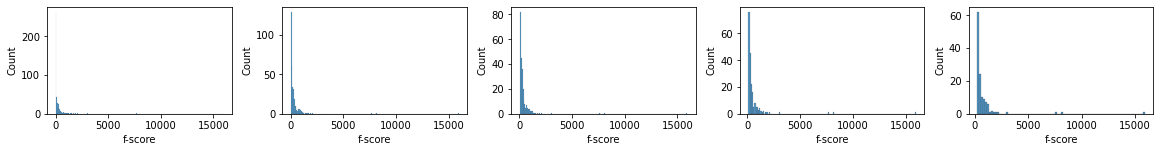

In [398]:
fig, axes = plt.subplots(1, 5, figsize=(16, 2), constrained_layout=True)
g1 = sns.histplot(x='f-score', data=anova, ax=axes[0])
g2 = sns.histplot(x='f-score', data=anova[anova['f-score']>10], ax=axes[1])
g3 = sns.histplot(x='f-score', data=anova[anova['f-score']>50], ax=axes[2])
g4 = sns.histplot(x='f-score', data=anova[anova['f-score']>100], ax=axes[3])
g4 = sns.histplot(x='f-score', data=anova[anova['f-score']>200], ax=axes[4])

In [393]:
for thresh in [0,10,50,100]:
    print('threshold =', thresh)
    print('max:', anova[anova['f-score']>thresh]['p-value'].max())

threshold = 0
max: 0.9883574678109508
threshold = 10
max: 0.0014061605622347807
threshold = 50
max: 1.181182345164663e-12
threshold = 100
max: 1.0681807068126723e-23


In [278]:
np.median(anova['f-score'])

44.14147483410649

In [279]:
np.mean(anova['f-score'])

232.4362639471128

In [280]:
anova_selected = anova[anova['f-score'] > 50]
anova_selected.sort_values('f-score',ascending=False)

,f-score,p-value,columns_name
56,15939.286359,0.000000e+00,NEW_EXT_SOURCE_MEAN
21,8109.493617,0.000000e+00,EXT_SOURCE_2
22,7659.890000,0.000000e+00,EXT_SOURCE_3
20,3036.648251,0.000000e+00,EXT_SOURCE_1
135,2085.799547,0.000000e+00,BURO_DAYS_CREDIT__mean
...,...,...,...
349,54.050020,1.959319e-13,PREV_CHANNEL_TYPE_Contact center__mean
378,53.284656,2.892433e-13,PREV_PRODUCT_COMBINATION_Cash X-Sell: middle__...
393,51.895406,5.867043e-13,prevAPPROVED_CNT_PAYMENT__mean
297,51.243645,8.176551e-13,PREV_CODE_REJECT_REASON_SCO__mean


In [324]:
anova_unselected = anova[anova['f-score'] < 50]
anova_unselected.sort_values('f-score',ascending=False)

,f-score,p-value,columns_name
52,49.643455,1.847687e-12,NEW_PAYMENT_RATE
241,49.444381,2.044985e-12,PREV_APP_SUCCESS_RATE__min_//_prevAPPROVED_APP...
126,49.247492,2.260848e-12,"WALLSMATERIAL_MODE_Stone, brick"
486,48.971011,2.603011e-12,CC_CNT_INSTALMENT_MATURE_CUM__min
53,48.275616,3.710599e-12,NEW_INC_PER_CHLD_//_NEW_INCOME_PER_PERSON_//_A...
...,...,...,...
287,0.004477,9.466508e-01,PREV_NAME_CASH_LOAN_PURPOSE_XNA__mean_//_PREV_...
217,0.002322,9.615640e-01,BURO_closed_AMT_CREDIT_SUM_OVERDUE__mean
39,0.001679,9.673116e-01,AMT_REQ_CREDIT_BUREAU_HOUR
254,0.001214,9.722108e-01,PREV_WEEKDAY_APPR_PROCESS_START_COS__min


In [388]:
print('if we drop the {} features with f-score <50, df would be with {} features'\
      .format(anova_unselected.shape[0],
              df.shape[1]-anova_unselected.shape[0]))

if we drop the 266 features with f-score <50, df would be with 245 features


### Strategy 4: based on a mix of dropping features with >50 % nan AND/OR correlated at >80% with another feature AND/OR f-score <50

In [302]:
#list of features correlated at > 80%
all_corr_cols2 = corr_cols2['feature_a'].tolist()
print(len(all_corr_cols2))
for e in corr_cols2['feature_b']:
    all_corr_cols2.append(e)
print(len(all_corr_cols2))
all_corr_cols2 = list(dict.fromkeys(all_corr_cols2))
print(len(all_corr_cols2))

319
638
242


* what if we drop features with >50% nan AND >80% correl AND <50 f-score?

    *==> no such feature --> df with same size*

In [303]:
# features with >50% nan AND >80% correl AND <50 f-score
feat_list = []
for feat in col_nan_sup_50b:
    for col in all_corr_cols2:
        if feat.startswith(col) == True:
            if feat in anova_unselected['columns_name']:
                feat_list.append(feat)
print('nb features = ', len(feat_list))

nb features =  0


* what if we drop features meeting 2 conditions among (1) having >50% nan, (2) being >80% correl, (3) having <50 f-score?

    *==> 74 features as such --> df would be with 437 features*

In [315]:
# features with >50% nan AND >80% correl OR <50 f-score
feat_list = []
for feat in col_nan_sup_50b:
    for col in all_corr_cols2:
        if feat.startswith(col) == True or feat in anova_unselected['columns_name']:
            feat_list.append(feat)
print('nb features = ', len(feat_list))

nb features =  41


In [316]:
feat_to_drop = [e for e in feat_list]
len(feat_to_drop)

41

In [317]:
# features with >80% correl AND <50 f-score
feat_list = []
for feat in anova_unselected['columns_name']:
    for col in all_corr_cols2:
        if feat.startswith(col) == True :
            feat_list.append(feat)
print('nb features = ', len(feat_list))

nb features =  51


In [318]:
print('nb features = ', len(feat_to_drop))
for e in feat_list:
    feat_to_drop.append(e)
print('nb features = ', len(feat_to_drop))
feat_to_drop = list(dict.fromkeys(feat_to_drop))
print('nb features = ', len(feat_to_drop))

nb features =  41
nb features =  92
nb features =  74


In [320]:
df.shape[1]-74

437

* what if we drop features with >50% nan OR >80% correl OR <50 f-score?

    *==> 385 features as such --> df would be with 126 features*

In [319]:
# features with >50% nan OR >80% correl OR <50 f-score
feat_list = [feat for feat in col_nan_sup_50b]
print('nb features = ', len(feat_list))
for col in all_corr_cols2:
    for feat in df.columns.tolist():
        if feat.startswith(col) == True:
            feat_list.append(feat)
print('nb features = ', len(feat_list))
for feat in anova_unselected['columns_name']:
    feat_list.append(feat)
print('nb features = ', len(feat_list))
feat_list = list(dict.fromkeys(feat_list))
print('nb features = ', len(feat_list))

nb features =  95
nb features =  244
nb features =  510
nb features =  385


In [313]:
df.shape[1]-385

126

* what if we drop features with >80% correl OR <50 f-score?

    *==> 364 features as such --> df would be with 147 features*

In [321]:
# features >80% correl OR <50 f-score
feat_list = [feat for feat in anova_unselected['columns_name']]
print('nb features = ', len(feat_list))
for col in all_corr_cols2:
    for feat in df.columns.tolist():
        if feat.startswith(col) == True:
            feat_list.append(feat)
print('nb features = ', len(feat_list))
feat_list = list(dict.fromkeys(feat_list))
print('nb features = ', len(feat_list))

nb features =  266
nb features =  415
nb features =  364


In [322]:
df.shape[1]-364

147

* what if we drop features with >50% nan OR <50 f-score?

    *==> 310 features as such --> df would be with 201 features*

In [337]:
# features >50% nan OR <50 f-score
feat_list = [feat for feat in anova_unselected['columns_name']]
print('nb features = ', len(feat_list))
for feat in col_nan_sup_50b:
    feat_list.append(feat)
print('nb features = ', len(feat_list))
feat_list = list(dict.fromkeys(feat_list))
print('nb features = ', len(feat_list))
print('df would have {} features'.format(df.shape[1]-len(feat_list)))

nb features =  266
nb features =  361
nb features =  310
df would have 201 features


In [385]:
# check f-score of features with >50% nan
anova_selected[anova_selected['columns_name'].isin(col_nan_sup_50b)].sort_values('f-score',ascending=False)

,f-score,p-value,columns_name
20,3036.648251,0.000000e+00,EXT_SOURCE_1
483,1126.304068,1.776282e-246,CC_CNT_DRAWINGS_CURRENT__std_//_CC_CNT_DRAWING...
477,751.374777,3.191665e-165,CC_AMT_TOTAL_RECEIVABLE__mean_//_CC_AMT_RECIVA...
482,690.948322,4.100791e-152,CC_CNT_DRAWINGS_CURRENT__mean
158,582.066752,1.755517e-128,BURO_MONTHS_BALANCE__size__mean_//_BURO_closed...
415,517.787292,1.595396e-114,prevREFUSED_APP_LVR__mean
414,508.346950,1.792138e-112,prevREFUSED_APP_LVR__max
468,495.199366,1.286294e-109,CC_AMT_DRAWINGS_CURRENT__std_//_CC_AMT_DRAWING...
476,419.971429,2.858770e-93,CC_AMT_TOTAL_RECEIVABLE__min_//_CC_AMT_RECIVAB...
27,389.182544,1.411064e-86,ELEVATORS_MEDI_//_ELEVATORS_AVG_//_ELEVATORS_MODE


In [383]:
# checking %nan of some of these features
df['EXT_SOURCE_1'].isna().sum()/df.shape[0]

0.5638115555093055

In [384]:
df['CC_CNT_DRAWINGS_CURRENT__std_//_CC_CNT_DRAWINGS_CURRENT__max'].isna().sum()/df.shape[0]

0.7173885472525828

### Strategy 3bis: based on other values of ANOVA f-score

* what if we drop features with <100 f-score? with <200 f-score?

In [400]:
thresh = 100
anova_unselected = anova[anova['f-score'] < thresh]
print('if we drop the {} features with f-score <{}, df would be with {} features'\
      .format(anova_unselected.shape[0],
              thresh,
              df.shape[1]-anova_unselected.shape[0]))

if we drop the 308 features with f-score <100, df would be with 203 features


In [401]:
thresh = 200
anova_unselected = anova[anova['f-score'] < thresh]
print('if we drop the {} features with f-score <{}, df would be with {} features'\
      .format(anova_unselected.shape[0],
              thresh,
              df.shape[1]-anova_unselected.shape[0]))

if we drop the 381 features with f-score <200, df would be with 130 features


In [405]:
anova_selected = anova[anova['f-score'] >= 200].sort_values('f-score',ascending=False)
anova_selected

,f-score,p-value,columns_name
56,15939.286359,0.000000e+00,NEW_EXT_SOURCE_MEAN
21,8109.493617,0.000000e+00,EXT_SOURCE_2
22,7659.890000,0.000000e+00,EXT_SOURCE_3
20,3036.648251,0.000000e+00,EXT_SOURCE_1
135,2085.799547,0.000000e+00,BURO_DAYS_CREDIT__mean
...,...,...,...
451,218.330525,2.175311e-49,INSTAL_PAYMENT_DIFF__sum
81,216.368512,5.823810e-49,NAME_FAMILY_STATUS_Single / not married
408,212.789445,3.511045e-48,prevREFUSED_APP_SUCCESS_RATE__min
508,210.440465,1.141686e-47,CC_COUNT_//_CC_MONTHS_BALANCE__std_//_CC_NAME_...


### Chosen strategy = drop features with f-score<200

In [407]:
del X
gc.collect()

2311270

In [408]:
thresh = 200
anova_unselected = anova[anova['f-score'] < thresh]
print('df shape BEFORE dropping features with f-score<200:', df.shape)
for feat in anova_unselected['columns_name']:
    df.drop(feat, axis=1, inplace=True)
print('df shape AFTER dropping features with f-score<200:', df.shape)

df shape BEFORE dropping features with f-score<200: (307507, 511)
df shape AFTER dropping features with f-score<200: (307507, 130)


### Visualising / checking the effect

In [409]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307507 entries, 0 to 307506
Columns: 130 entries, SK_ID_CURR to CC_COUNT_//_CC_MONTHS_BALANCE__std_//_CC_NAME_CONTRACT_STATUS_Active__sum_//_CC_MONTHS_BALANCE__std_//INV_CC_MONTHS_BALANCE__sum_//_CC_MONTHS_BALANCE__min_//_CC_MONTHS_BALANCE__mean_//_CC_MONTHS_BALANCE__min_//INV_CC_MONTHS_BALANCE__mean_//_CC_MONTHS_BALANCE__min_//INV_CC_MONTHS_BALANCE__min
dtypes: float64(105), int64(25)
memory usage: 305.0 MB


In [413]:
check_nan(df)

nan in SK_ID_CURR : 0 (ratio of 0.0 )
nan in TARGET : 0 (ratio of 0.0 )
nan in CODE_GENDER : 0 (ratio of 0.0 )
nan in AMT_CREDIT_//_AMT_GOODS_PRICE : 0 (ratio of 0.0 )
nan in REGION_POPULATION_RELATIVE : 0 (ratio of 0.0 )
nan in DAYS_REGISTRATION : 0 (ratio of 0.0 )
nan in DAYS_ID_PUBLISH : 0 (ratio of 0.0 )
nan in FLAG_WORK_PHONE : 0 (ratio of 0.0 )
nan in REG_CITY_NOT_LIVE_CITY : 0 (ratio of 0.0 )
nan in REG_CITY_NOT_WORK_CITY : 0 (ratio of 0.0 )
nan in LIVE_CITY_NOT_WORK_CITY : 0 (ratio of 0.0 )
nan in EXT_SOURCE_1 : 173376 (ratio of 0.56 )
nan in EXT_SOURCE_2 : 660 (ratio of 0.0 )
nan in EXT_SOURCE_3 : 60965 (ratio of 0.2 )
nan in ELEVATORS_MEDI_//_ELEVATORS_AVG_//_ELEVATORS_MODE : 163890 (ratio of 0.53 )
nan in FLOORSMAX_MEDI_//_FLOORSMAX_AVG_//_FLOORSMAX_MODE : 153019 (ratio of 0.5 )
nan in TOTALAREA_MODE_//_LIVINGAREA_AVG_//_LIVINGAREA_MEDI_//_LIVINGAREA_AVG_//_LIVINGAREA_MODE : 148286 (ratio of 0.48 )
nan in DEF_30_CNT_SOCIAL_CIRCLE : 1021 (ratio of 0.0 )
nan in DEF_60_CNT_SOCI

In [424]:
corr= df.iloc[:,1:].corr()

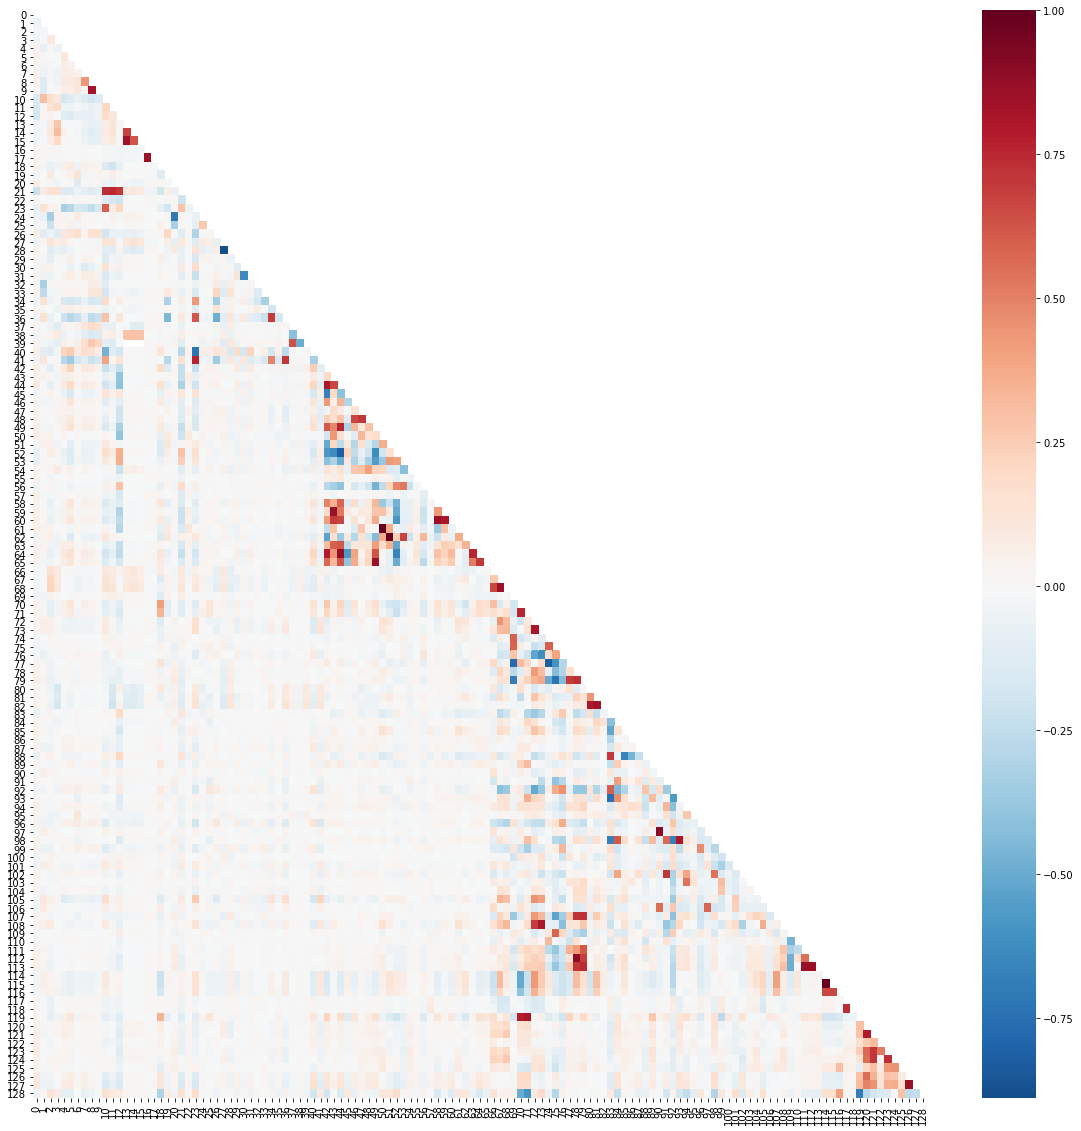

In [422]:
plt.figure(figsize=(20,20))
MASK = np.triu(corr)
sns.heatmap(corr,annot=False, fmt='.1f', cmap ="RdBu_r",
            center=0, mask=MASK,
            xticklabels=[i for i in range (corr.shape[0])],
            yticklabels=[i for i in range (corr.shape[0])])
plt.show()

In [425]:
corr.loc[:,:] = np.tril(corr.values, k=-1)
corr_ = corr[corr!=0]

# Filter according to threshold of 0.8 (taking out features already dealt with)
corr_ = corr_[((corr_ >= 0.9) | (corr_ <= -0.9))]

# Unstack, sort ascending, and reset the index, so features are in columns
# instead of indexes (allowing e.g. a pretty print in Jupyter).
# Also rename these it for good measure.
corr_cols = corr_.unstack().sort_values(ascending=False)\
    .drop_duplicates().dropna().reset_index()\
    .rename(columns={"level_0": "feature_a", "level_1": "feature_b", 0: "correlation"})
corr_cols

,feature_a,feature_b,correlation
0,POS_MONTHS_BALANCE__size,POS_COUNT,1.0


In [426]:
# Why is there one left??????
# correcting this:
corr_feat_todrop_list = []
corr_feat_kept_list = []
nb_feat_before = df.shape[1]

for i in range(corr_cols.shape[0]):
    feat_a = [e for e in df.columns.tolist() if e.startswith(corr_cols.loc[i, 'feature_a']) == True][0]
    feat_b = [e for e in df.columns.tolist() if e.startswith(corr_cols.loc[i, 'feature_b']) == True][0]
    # For each pair of features highly correlated, we will keep the feature with less NaN, and drop the other
    if df[feat_a].isna().sum() < df[feat_b].isna().sum():
        feat_tokeep = feat_a
        feat_todrop = feat_b
    else:
        feat_tokeep = feat_b
        feat_todrop = feat_a
    corr_feat_todrop_list.append(feat_todrop)
    corr_feat_kept_list.append(feat_tokeep)
    # Before doing it, we will replace NaN of the feature to keep 
    # by normalized (relative to feat_tokeep) values from the feature to drop
    # For this we need min and max values of both features:
    min_k = np.min(df[feat_tokeep])
    max_k = np.max(df[feat_tokeep])
    min_d = np.min(df[feat_todrop])
    max_d = np.max(df[feat_todrop])
    # to track nb of nan replaced:
    nb_nan_before = df[feat_tokeep].isna().sum()
    # And we will rename the feature kept by adding to its initial name the dropped feature's name
    # in 2 different ways depending if these features are positively or negatively correlated
    if corr_cols.loc[i, 'correlation'] > 0:
        df[feat_tokeep].fillna((max_k-min_k)*(((df[feat_todrop]-min_d)/(max_d-min_d))+(min_k/(max_k-min_k))),
                            inplace=True)
        df.rename(columns={feat_tokeep: feat_tokeep+'_//_'+feat_todrop}, inplace=True)
        nb_nan_after = df[feat_tokeep+'_//_'+feat_todrop].isna().sum()
    if corr_cols.loc[i, 'correlation'] < 0:
        df[feat_tokeep].fillna((min_k-max_k)*(((df[feat_todrop]-min_d)/(max_d-min_d))+(max_k/(min_k-max_k))),
                            inplace=True)
        df.rename(columns={feat_tokeep: feat_tokeep+'_//INV_'+feat_todrop}, inplace=True)
        nb_nan_after = df[feat_tokeep+'_//INV_'+feat_todrop].isna().sum()
    print('{}-- feature kept: {}, feature to drop: {}, nb nan replaced:{}'.format(i,feat_tokeep, feat_todrop,
                                                                             (nb_nan_before-nb_nan_after)))

# Dropping features to drop
corr_feat_todrop_list = list(dict.fromkeys(corr_feat_todrop_list)) # to remove duplicates from the list of features to drop
corr_feat_todrop_list_ = [col for col in df.columns for e in corr_feat_todrop_list if col.startswith(e) == True]
corr_feat_todrop_list_ = list(dict.fromkeys(corr_feat_todrop_list_))
print('-' * 100)
print('####### dropping {} features now...'.format(len(corr_feat_todrop_list_)))
    # dropping them   
for feat in corr_feat_todrop_list_:
    print(feat)
    df.drop(feat, axis=1, inplace=True)
print('-' * 100)
print('df shape after dropping one feature from each pair of highly correlated (0.9) features:', df.shape)
print('nb of dropped features = ', nb_feat_before - df.shape[1]) # as a reminder at the bottom

0-- feature kept: POS_COUNT, feature to drop: POS_MONTHS_BALANCE__size, nb nan replaced:0
----------------------------------------------------------------------------------------------------
####### dropping 1 features now...
POS_MONTHS_BALANCE__size
----------------------------------------------------------------------------------------------------
df shape after dropping one feature from each pair of highly correlated (0.9) features: (307507, 129)
nb of dropped features =  1


In [430]:
# Exporting the resulting df to be used for modelling
df.to_csv('combined_light2_df.csv')

# EDA: usefull plots regarding feature distribution or relation to other features 
## Distribution of target feature

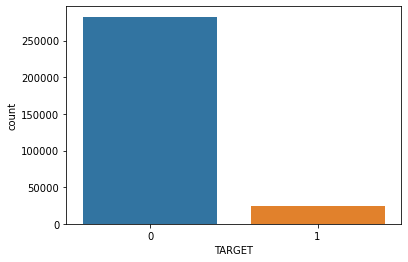

In [353]:
sns.countplot(x='TARGET', data=df)

In [377]:
target_val = df['TARGET'].value_counts()

Text(0.5, 1.0, 'TARGET')

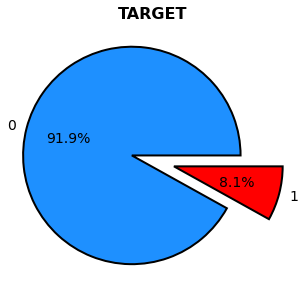

In [380]:
colors = ('dodgerblue', 'red')
target_val.plot.pie(autopct='%1.1f%%', label='', figsize=(5, 5), fontsize=14, 
                    #colormap='tab20', 
                    colors = colors,
                    wedgeprops={"edgecolor":"k",'linewidth': 2, 'antialiased': True},
                    explode=[0.2, 0.2])
plt.title('TARGET', fontsize=16, fontweight='bold')

## Bivariate plots: significant feature-feature relation 
## Effect of Age on Repayment

In [42]:
df=pd.read_csv('combined_light2_df.csv')

In [45]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [47]:
df.shape

(307507, 129)

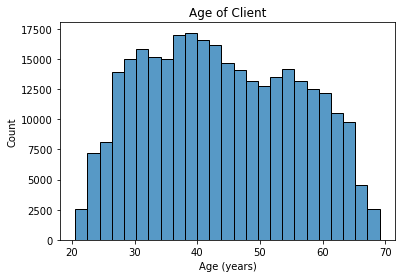

In [53]:
g1 = sns.histplot(x='NEW_AGE_//INV_DAYS_BIRTH', data=df, bins=25)
plt.title('Age of Client')
plt.xlabel('Age (years)')
plt.ylabel('Count')

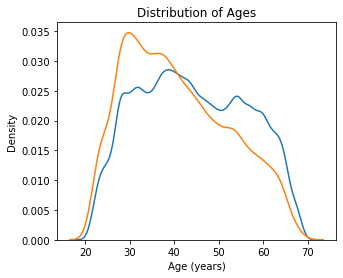

In [57]:
plt.figure(figsize = (5, 4))

# KDE plot of loans that were repaid on time
sns.kdeplot(df.loc[df['TARGET'] == 0, 'NEW_AGE_//INV_DAYS_BIRTH'], label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(df.loc[df['TARGET'] == 1, 'NEW_AGE_//INV_DAYS_BIRTH'], label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

<ipython-input-60-e773f2ece3ef>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_data['YEARS_BINNED'] = pd.cut(age_data['NEW_AGE_//INV_DAYS_BIRTH'], bins = np.linspace(20, 70, num = 11))


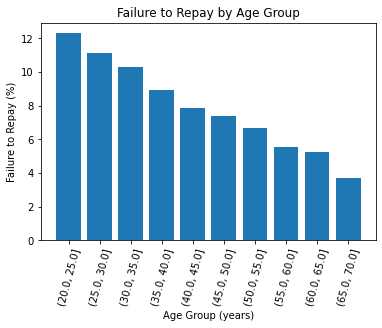

In [60]:
# Age information into a separate dataframe
age_data = df[['TARGET', 'NEW_AGE_//INV_DAYS_BIRTH']]
#age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['NEW_AGE_//INV_DAYS_BIRTH'], bins = np.linspace(20, 70, num = 11))

# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups


plt.figure(figsize = (6, 4))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

==> younger applicants are more likely not to repay their loan.

## Exterior source scores

Text(0.5, 1.0, 'Correlation Heatmap')

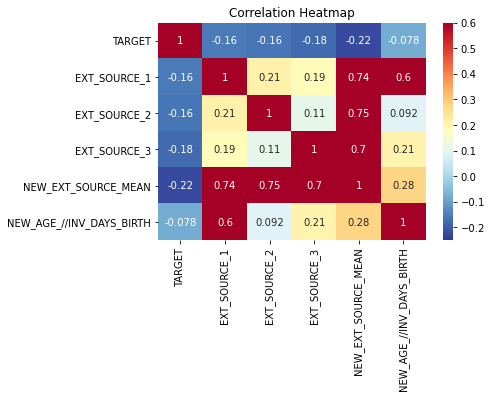

In [61]:
ext_data = df[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'NEW_EXT_SOURCE_MEAN', 'NEW_AGE_//INV_DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()

plt.figure(figsize = (6, 4))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap')

* All EXT_SOURCE features are negatively correlated to the target ==> as the value of the EXT_SOURCE increases, the client is more likely to repay the loan.

* DAYS_BIRTH is positively correlated to EXT_SOURCE_1 ==> might be one element taken into consideration when calculating this score

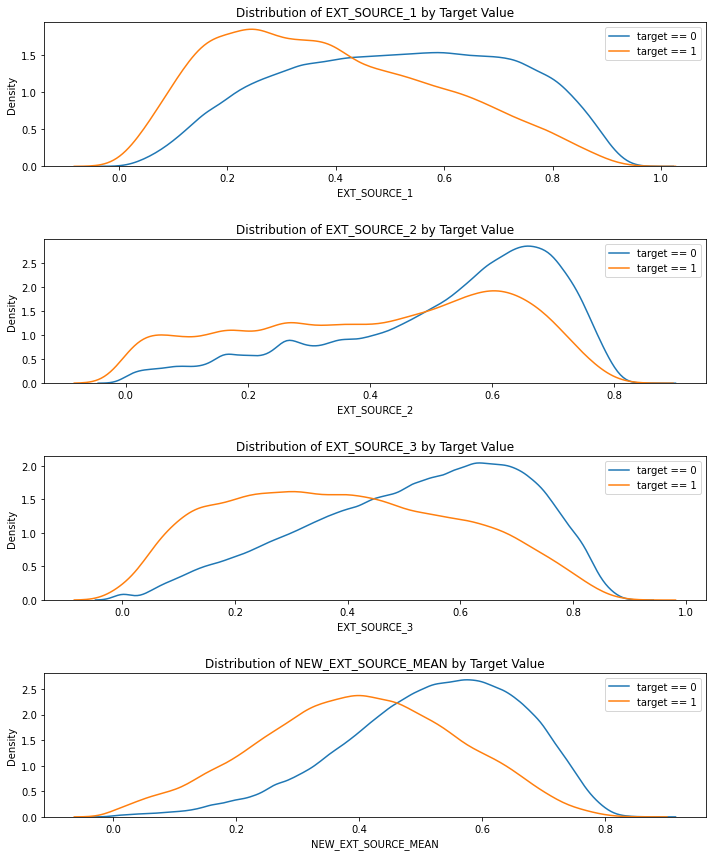

In [64]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'NEW_EXT_SOURCE_MEAN']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(df.loc[df['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(df.loc[df['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density'); 
    plt.legend()
    
plt.tight_layout(h_pad = 2.5)

## Exploring some features newly created

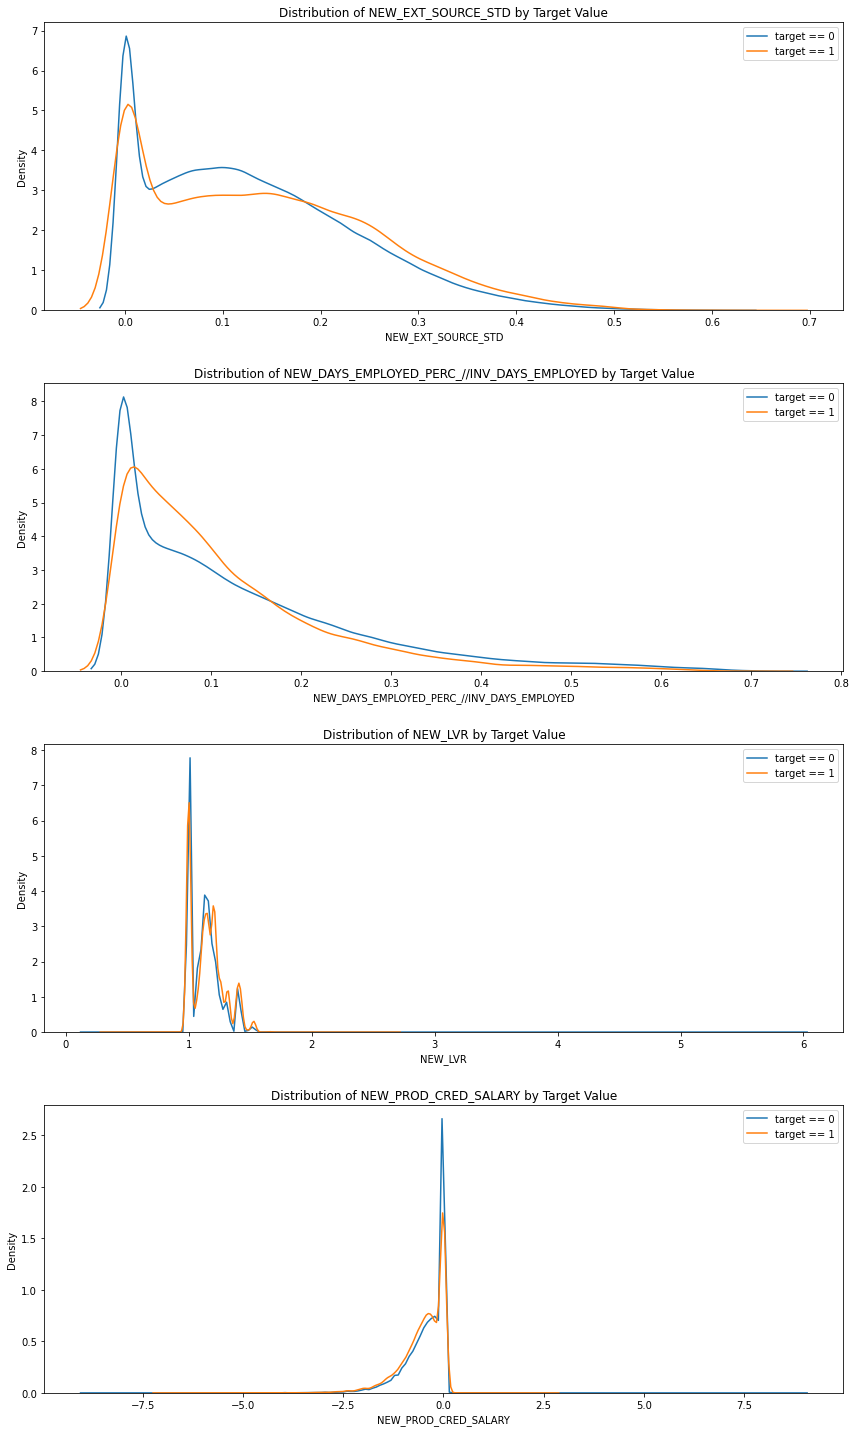

In [65]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['NEW_EXT_SOURCE_STD', 
                             'NEW_DAYS_EMPLOYED_PERC_//INV_DAYS_EMPLOYED',
                             'NEW_LVR',
                             'NEW_PROD_CRED_SALARY']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(df.loc[df['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(df.loc[df['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    plt.legend()
    
plt.tight_layout(h_pad = 2.5)

==> no substancial differences within those variables between the two target classes... 